We need custom Reducers which append list made out of classes , based on values of attributes in this classes


1 We need to change architecrure of flow. HyDe genareation must be implemented as subgraph
It will share with main hyde scores
But what if we want to keep and check quality of hyde documents(DOne)


In [1]:
# By chat model we mean LLM model which operates with chats 
import os 
import time
import re

import json
import operator
from openai import OpenAI

import threading
from urllib.parse import urlparse

from langchain_openai import ChatOpenAI 
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field
from typing import Literal , Optional

## check performance in agent workflow 
from typing import TypedDict, Annotated, List, Dict, Optional, Set
from langchain_core.messages import BaseMessage, AnyMessage, ToolMessage,HumanMessage, AIMessage, SystemMessage
from langgraph.graph import add_messages , START, END , StateGraph
from IPython.display import Image, display 
from langgraph.checkpoint.memory import MemorySaver

from googleapiclient.discovery import build
from urllib.parse import urlparse

# prepare model for embeddings  
from langchain_openai import OpenAIEmbeddings 
from langchain_core.tools import tool, StructuredTool


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import numpy.typing as npt

from tavily import TavilyClient 

import subprocess
from IPython.display import Image, display


d:\MICB_Projects\8_aml_detective\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.11) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
class APIVault():
    def __init__(self):  # Fixed: single underscore
        self._keys = {}

    def add_key(self, key_name: str, key_value: str):
        """Add API key to the vault"""
        if not key_name:
            print("Key name is empty")
        elif not key_value:  # Added check for value
            print(f"Key value is empty for '{key_name}'")
        else:   
            self._keys[key_name] = key_value
        
    def get_key(self, key_name: str):
        """Get an API key from the vault"""
        if key_name not in self._keys:
            print("Key is not present in Vault")
            return None  # Added return
        else:
            return self._keys[key_name]  # Fixed: use _keys dict


In [3]:
## populate classes
key_vault = APIVault()
key_vault.add_key( "openai_key" , os.environ.get("OPENAI_API_KEY")) # personal api key
key_vault.add_key("tavily_key" ,os.environ.get("TAVILY_API_KEY")) # for tavily search and extract
key_vault.add_key("google_key" ,os.environ.get("GOOGLE_API_KEY")) # gor google search engine
key_vault.add_key("openai_key_azure_41" , os.environ.get("OPENAI_API_KEY_AZURE_41")) # for azure project for gpt 4.1
key_vault.add_key("dummy" , os.environ.get("dummy")) # to test error mesage
key_vault.add_key("perplexity_key" , os.environ.get("PERPLEXITY_API_KEY")) # to test error mesage


Key value is empty for 'dummy'


In [4]:
# Support for Google API 
# define search engine
SEARCH_ENGINE_ID = '26dda816634bd4044'

## Azure service 
endpoint = 'https://datam-mhtcc5x5-westeurope.cognitiveservices.azure.com/openai/v1'
# The SDK automatically appends /chat/completions and other paths

# azure https://datam-mhtcc5x5-westeurope.cognitiveservices.azure.com/openai/deployments/gpt-4.1/chat/completions?api-version=2025-01-01-preview
# This is the direct REST API endpoint, Used for raw HTTP requests (curl, requests library, etc.)

## Path to prompts
CURRENT_DIR = os.getcwd()
PROMPTS_TOOLS = os.path.join(CURRENT_DIR , "prompts\prompts_search_tools.txt")
PROMPTS_STR_OUTPUT = os.path.join(CURRENT_DIR , "prompts\prompts_structured_output.txt")

print(PROMPTS_TOOLS)
print(PROMPTS_STR_OUTPUT)


d:\MICB_Projects\8_aml_detective\prompts\prompts_search_tools.txt
d:\MICB_Projects\8_aml_detective\prompts\prompts_structured_output.txt


#### Embeddings for similarity Search

In [5]:
# Prepare embedding model
embedding_main = OpenAIEmbeddings(api_key=key_vault.get_key("openai_key"), model="text-embedding-3-small")
embedding_cross_lang = OpenAIEmbeddings(api_key=key_vault.get_key("openai_key"), model="text-embedding-3-large")


In [6]:
# !jupyter nbconvert --to python 4_6_2_research_assistant.ipynb

#### LLM models api definition

In [7]:
# LLM to select tool, populate class with restricted output, [ tools_name_1, ... ,  exit scenario  ]
# short deterministic outputs
llm_tool_selection = ChatOpenAI(
    model="gpt-4.1-mini",  
    temperature=0.2,     
    max_tokens=50, # Max number of tokens to generate. |
    top_p=0.95,          
    timeout=30,  
    max_retries = 2,
    api_key=key_vault.get_key("openai_key")       
) # OpenAI API key. If not passed in will be read from env var OPENAI_API_KEY. |


# Model to create payload for search tools, its pivotal to create exactly 5 queries, add retry logic inside node
llm_search_tool_payload = ChatOpenAI(
    model="gpt-4.1-mini",  
    temperature=0.2,     
    max_tokens=1000, # 5 outputs per 5 languages     
    top_p=0.95,          
    timeout=30,  
    max_retries = 2,
    api_key=key_vault.get_key("openai_key")             
)

## we also need to generate names variations in different languages
## output become input to geenerate regular expression , google search allows search modifiers but other search tools may not
llm_names_variation = ChatOpenAI(
    model="gpt-4.1-mini",   # note the hyphen
    temperature=0.0,        # pure extraction/translation
    max_tokens=50,          # we only need one short line
    timeout=30,  
    max_retries = 2,
    api_key=key_vault.get_key("openai_key")    
)


# Translation and key terms extraction from short input
llm_translation_or_terms = ChatOpenAI(
    model="gpt-4.1-mini",  
    temperature=0.1,      
    max_tokens=500,       
    timeout=30,           
    max_retries=2,         
    api_key=key_vault.get_key("openai_key")                         
)


# # generate persona
llm_expert_generation = ChatOpenAI(
    model="gpt-4.1-mini",     # BETTER: Cheaper, perfectly capable for structured output
    temperature=0.2,         # BEST: Near-deterministic for consistent structure
    max_tokens=1000,         
    timeout=60,             
    max_retries=3,           # ADEQUATE: Structured output usually works first try
    api_key=key_vault.get_key("openai_key")   
)
# LengthFinishReasonError: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=200, prompt_tokens=426, total_
# APITimeoutError: Request timed out.
# 4.0 mini replaced with 4.1 as it offers larger context allowing to simulate more experts


llm_hyde_generation = ChatOpenAI(
    model="gpt-4.1-mini",     # OPTIMAL: Cost-effective for creative writing
    temperature=0.5,         # BEST: Creative variation for different journalist styles
    max_tokens=500,          
    timeout=60,            
    max_retries=3,
    api_key=key_vault.get_key("openai_key")             
)


########################################### AZURE
# Duw to error below , before we get better result, try personal data.

# Error generating reputation summary: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your 
# prompt and retry. To learn more about our content filtering policies please read our documentation:
# https://learn.microsoft.com/en-us/answers/questions/1297066/i-keep-getting-this-error-exception-in-chat-messag

#Error generating reputation summary: Error code: 429 - {'error': {'code': 'RateLimitReached', 'message': 
#'Your requests to gpt-4.1 for gpt-4.1 in West Europe have exceeded the token rate limit for your current AIServices S0 pricing tier. This request was for ChatCompletions_Create under OpenAI Language Model Instance API. Please retry after 60 seconds. To increase your default rate limit, visit: https://aka.ms/oai/quotaincrease.'}}

# Summary of content extracted from URL with tavily, applieed per each link
llm_url_content_summary = ChatOpenAI(
    api_key=key_vault.get_key("openai_key"),    
    #base_url = f"{endpoint}" , 
    #api_key = key_vault.get_key("openai_key_azure_41"), 
    model="gpt-4.1",  # BETTER CHOICE: Your original "gpt-4o" was budget-killer
                          # URL content analysis is mostly extraction/summarization
    
    temperature=0.2,      # BEST: Factual analysis needs consistency, not creativity
    max_tokens=2000,     
    top_p=0.95,         
    timeout=60,
    max_retries=3           
)


# Applied for extract_evidence_claims, consolidates results from Multiple summaries
llm_agg_summaries = ChatOpenAI(
    #api_key=key_vault.get_key("openai_key"), 
    base_url = f"{endpoint}" , 
    api_key = key_vault.get_key("openai_key_azure_41") , 

    model="gpt-4.1", 
    temperature=0.1,      
    max_tokens=2000,     
    top_p=0.95,          
    timeout=60,          
    max_retries=3        
)


# Model uses multiple summaries to make conclusion about possible risk 
llm_evaluation = ChatOpenAI( # compare to 4.o should have better instrusction following
    #api_key=key_vault.get_key("openai_key"), 
    base_url = f"{endpoint}" , 
    api_key = key_vault.get_key("openai_key_azure_41") , 
    model="gpt-4.1", # BadRequestError: Error code: 400 - {'error': {'code': 'unknown_model', 'message': 'Unknown model: gpt-4.o', 'details': 'Unknown model: gpt-4.o'}}      
    temperature=0.2,                   
    max_tokens=3000,     
    top_p=0.95, # not applicable for 5 openai family        
    timeout=60,          
    max_retries=3        
)

# BadRequestError: Error code: 400 - {'error': {'message': "Unsupported parameter: 'top_p' is not supported with this model.", 
# 'type': 'invalid_request_error', 'param': 'top_p', 'code': 'unsupported_parameter'}}

## test gpt 5, takes signifficnt time, requires larger timeout
# result = llm_evaluation.invoke("Generate recommendations on how to prepare banana bread")



#### Variations of company names

In [8]:
## now genetate variation names 

def generate_name_regex(company_name: str, llm) -> tuple[ list[str], re.Pattern]:
    """
    Returns:
        pipe_line: "Original | Russian"
        parts: [Original, Russian]
        name_re: compiled regex matching either variant (case-insensitive)
    """
    prompt = f"""
    You are an expert at generating a single-line string of company name variants separated by '|'.

    OUTPUT FORMAT (choose exactly one based on spaces in the Original name):
    - If the Original name CONTAINS whitespace:
    <ORIGINAL_NAME>|<RUSSIAN_NAME>|<ORIGINAL_NO_SPACES>|<RUSSIAN_NO_SPACES>
    - If the Original name DOES NOT CONTAIN whitespace:
    <ORIGINAL_NAME>|<RUSSIAN_NAME>

    Rules:
    - ORIGINAL_NAME = the input company name verbatim (do not modify punctuation, casing, or suffixes).
    - RUSSIAN_NAME = a **transliteration/phonetic rewrite** of ORIGINAL_NAME into Cyrillic. **Do NOT translate any words** (brand words, common nouns, legal suffixes, country names, etc.). Only rewrite letters to approximate English pronunciation. If the input is already Cyrillic/Russian, repeat it verbatim. If unsure, copy the original as is.
    - ORIGINAL_NO_SPACES = ORIGINAL_NAME with ALL whitespace removed (preserve punctuation/casing). Include ONLY if the Original name contains whitespace.
    - RUSSIAN_NO_SPACES = RUSSIAN_NAME with ALL whitespace removed (preserve punctuation/casing). Include ONLY if the Original name contains whitespace.
    - Preserve hyphens, punctuation, and casing exactly where they appear in ORIGINAL_NAME.
    - Output MUST be exactly one line, no leading/trailing spaces, no extra spaces around '|', no quotes, no notes, no extra variants, no newlines.

    Original name: {company_name}
    """.strip()


    resp = llm.invoke(prompt)
    pipe_line = (getattr(resp, "content", "") or "").strip()

    # Parse "Original | Russian", fallback to original if needed
    parts = [p.strip() for p in pipe_line.split("|")]

    # Compile strict, case-insensitive pattern
    pattern_str = r"(?:%s)" % "|".join(map(re.escape, parts))
    name_re = re.compile(pattern_str, re.IGNORECASE)

    return parts, name_re


## test 
parts, name_re = generate_name_regex("Danube Logistics", llm_names_variation)
print("Variants:", parts)

tests = [
    "Our vendor is Danube Logistics for Q4.",
    "Our vendor is DANUBE LOGISTICS for Q4.",
    "our vendor is danube logistics for q4.",
    "Payment processed for DanubeLogistics yesterday.",
    "PAYMENT PROCESSED FOR DANUBELOGISTICS YESTERDAY.",
    "payment processed for danubelogistics yesterday.",
    "He said \"Danube Logistics\" will handle shipping.",
    "Contract signed with DanubeLogistics, terms apply.",
    "Partners — Danube Logistics — confirmed attendance.",
    "Client=DanubeLogistics; status=active.",
]

for i, s in enumerate(tests, 1):
    print(f"{i:02d}. {'MATCH' if name_re.search(s) else 'NO MATCH'} — {s}")


Variants: ['Danube Logistics', 'Данюб Лоджистикс', 'DanubeLogistics', 'ДанюбЛоджистикс']
01. MATCH — Our vendor is Danube Logistics for Q4.
02. MATCH — Our vendor is DANUBE LOGISTICS for Q4.
03. MATCH — our vendor is danube logistics for q4.
04. MATCH — Payment processed for DanubeLogistics yesterday.
05. MATCH — PAYMENT PROCESSED FOR DANUBELOGISTICS YESTERDAY.
06. MATCH — payment processed for danubelogistics yesterday.
07. MATCH — He said "Danube Logistics" will handle shipping.
08. MATCH — Contract signed with DanubeLogistics, terms apply.
09. MATCH — Partners — Danube Logistics — confirmed attendance.
10. MATCH — Client=DanubeLogistics; status=active.


#### Main classes for workflow

In [9]:
## Support for journalists and HyDe articles 

class Journalist(BaseModel): # generates multiple values in single call
    expertise: str = Field(
        description="Primary area of expertise and writing focus."
    )
    perspective: str = Field(
        description="Writing perspective and approach to the topic."
    )
    style: str = Field(
        description="Writing style, tone, and target audience."
    )

class HydePerspectives(BaseModel):
      journalists: List[ Journalist ] = Field( "Comprehensive list of analysts with their roles and affiliations." )


## test generation of personalitis 
expert_instructions = """

You are creating exactly {max_journalists} AI journalist personas to analyze 
the SAME financial-crime topic from DIFFERENT, NON-OVERLAPPING angles for banking risk assessment.

Topic under investigation: {crime_topic}
Goal: Create persona of journalist which has solid experience in writing articles which occuses company over involement in  {crime_topic}.

OUTPUT FORMAT (MANDATORY)
- Return ONLY a valid HydePerspectives object with exactly {max_journalists} journalists.
- Each journalist has exactly these fields:
  - expertise (short phrase)
  - perspective (2-3 sentences)
  - style (6-10 adjectives/descriptors, comma-separated)
- No extra commentary, headings, or prose.

For each journalist:
- expertise: Their specific risk assessment specialization
- perspective: From what perspective they asses the impact of crime over diffenret economical or social aspects
- style: Their analytical approach to uncovering risks relevant to banking partnerships

UNIQUENESS REQUIREMENTS (MANDATORY)
- Pairwise distinct expertise (not just synonyms; avoid generic labels like “risk analyst”).
- Pairwise distinct perspectives (each must emphasize different indicators/decision criteria).
- style must contain 3–6 tokens; at least TWO tokens must be unique to that persona (not used by any other persona).
- Before returning, self-check all pairs. If any two personas substantially overlap in expertise keywords OR share >50% of style tokens OR rephrase the same perspective, REVISE and re-check.
  
- If {max_journalists} ≥ 5, ensure at least one persona implicitly covers each of these example 
  archetypes (use them as inspiration; do NOT output role names, reflect them via fields only):
  1) Regulatory Compliance Analyst — statutory/enforcement exposure
  2) Financial Due Diligence Investigator — flows/counterparties/anomalies
  3) Operational Risk Assessor — governance/controls/third-party risk
  4) Reputational Risk Evaluator — media patterns/controversy persistence
  5) KYC/AML Specialist — KYC gaps/BO transparency/PEP & sanctions
- If {max_journalists} < 5, prioritize coverage in this order: KYC/AML → Regulatory → Financial.

FIELD WRITING RULES
- expertise: one crisp, specific phrase tied to the angle (no generic titles).
- perspective: 1–2 sentences listing the key indicators/thresholds/heuristics used to decide on partnership risk (e.g., “weights unresolved consent orders more than remedial plans”).
- style: 3–6 concise descriptors shaping tone/approach (e.g., “forensic, evidence-driven, regulation-centric, conservative”). Ensure ≥2 tokens unique to this persona.

Return ONLY the HydePerspectives object with exactly {max_journalists} journalists."""


system_message = expert_instructions.format( crime_topic = "money laundering" , max_journalists= 2)
structured_llm = llm_expert_generation.with_structured_output( HydePerspectives )

# populate values  
journalists = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of journalists according to instructions")])

# hasattr(journalists,"journalists") # check if attribute is present in the class
journalists.model_dump()


{'journalists': [{'expertise': 'KYC and Beneficial Ownership Transparency',
   'perspective': 'Focuses on identifying risks through gaps in customer due diligence, especially opaque beneficial ownership structures and politically exposed persons. Prioritizes thorough verification of client identities and flags entities with inconsistent or incomplete KYC data as high risk for laundering activities.',
   'style': 'methodical, detail-oriented, compliance-focused, investigative, precise, client-centric'},
  {'expertise': 'Regulatory Enforcement and Compliance Breach Analysis',
   'perspective': 'Assesses money laundering risk by analyzing a company’s history of regulatory sanctions, unresolved enforcement actions, and adherence to AML statutory requirements. Emphasizes the weight of past penalties and ongoing regulatory scrutiny as indicators of elevated partnership risk.',
   'style': 'authoritative, evidence-driven, regulation-centric, critical, precedent-aware, enforcement-focused'}]}

In [10]:
# Evidence Lineage tracking 

# We have to guarantee
# Accountability: Every claim is traced to specific source
# Credibility: Check if the claim is supported by evidence

AllowedClaimType = Literal["allegation","investigation","charge","conviction","settlement","sanction_listing","other"]

# will store consolidated evidences into single ongect with supportive LLM
# additinally supporting_urls, each of them must be present in a pool of all url indicated across all LinkCollection 
class EvidenceClaim(BaseModel):
    """Track claims extracted from summaries - focused on consolidation"""
    claim_text: str = Field(description="Specific claim made (e.g., 'FinCEN fined company €50M in 2023')")
    claim_type: AllowedClaimType = Field(description="Each article must fit specific only 1 claim type") # should be generated during classification
    supporting_urls: List[str] = Field(description="ALL URLs that mention this claim")
    date_publish: str = Field(description=" Publication date or event date ")

class ClaimsFromSummaries( BaseModel ): 
    evidence_claims: List[EvidenceClaim] = Field(description="All extractable claims from the summaries")

# test 
test_prompt = """
You are an expert analyst extracting evidence claims from investigation summaries.

Extract ALL distinct claims from the summaries below. Consolidate duplicate claims that appear across multiple sources.

IMPORTANT RULES:
1. Each claim must be specific and factual (e.g., "FinCEN fined BankCorp $50M in March 2023")
2. Assign ONE claim_type per claim from: allegation, investigation, charge, conviction, plea, fine, settlement, clearance, sanction_listing, other
3. supporting_urls must include ALL URLs that mention this claim
4. date_publish should be the publication date or event date mentioned in the summary

SUMMARIES DATA:
{summaries_json}

Extract claims following the ClaimsFromSummaries schema. Consolidate overlapping claims from different sources.
"""

# Example dummy summaries data for testing
dummy_summaries = [
    {
        "url": "https://example.com/article1",
        "date": "2023-03-15",
        "summary": "FinCEN imposed a $50 million fine on BankCorp in March 2023 for AML violations. The investigation started in 2021 after suspicious transaction reports."
    },
    {
        "url": "https://example.com/article2",
        "date": "2023-03-16",
        "summary": "BankCorp received $50M penalty from FinCEN for failing to maintain adequate AML controls. Charges were filed in early 2022."
    },
    {
        "url": "https://example.com/article3",
        "date": "2023-06-10",
        "summary": "Separately, CEO John Smith was placed on EU sanction list in June 2023 for alleged money laundering connections."
    },
    {
        "url": "https://example.com/article4",
        "date": "2023-07-01",
        "summary": "BankCorp reached settlement agreement with regulators. John Smith's sanctions confirmed by OFAC."
    }
]

# Usage json.dumps returns string representation of the json data
test_prompt_filled = test_prompt.format(summaries_json=json.dumps(dummy_summaries, indent=2))
# print(test_prompt_filled)

structured_llm = llm_agg_summaries.with_structured_output( ClaimsFromSummaries )

response = structured_llm.invoke([
        SystemMessage(content= f"""
                You are a forensic Financial Crimes Analysts of company 

                Follow these constraints:
                - Use only information contained in the user message; do not add outside knowledge.
                - Do not guess missing details (dates, amounts, agencies).
                - Produce consolidated, non-duplicative claims and include provenance (supporting URLs).
                - Choose exactly one claim_type per claim, using the schema provided by the user.
                - If nothing qualifies under these constraints, return an empty list.
                
                """ )
                ,      

        HumanMessage(content=test_prompt_filled)
        
    ])

response


ClaimsFromSummaries(evidence_claims=[EvidenceClaim(claim_text='FinCEN imposed a $50 million fine on BankCorp in March 2023 for AML violations.', claim_type='settlement', supporting_urls=['https://example.com/article1', 'https://example.com/article2', 'https://example.com/article4'], date_publish='2023-03-15'), EvidenceClaim(claim_text='Charges were filed against BankCorp in early 2022 for failing to maintain adequate AML controls.', claim_type='charge', supporting_urls=['https://example.com/article2'], date_publish='2022-01-01'), EvidenceClaim(claim_text='CEO John Smith was placed on the EU sanction list in June 2023 for alleged money laundering connections.', claim_type='sanction_listing', supporting_urls=['https://example.com/article3', 'https://example.com/article4'], date_publish='2023-06-10')])

In [11]:
# Data and Meta for extracted content, per single link

# First model selects tool and return it, then 
# we pass specific System message to LLM with Tools.
# So essentially:
# Get Name of Tool -> Select System Message -> Pass system message to LLM with Tools

ToolsPool = Literal["google_search","perplexity_search","tavily_search","exit_scenario"]

class Tool_Selected(BaseModel):
       search_engine:ToolsPool = Field(default="" , description="Name of tool used to suggest url link") # taken from tool call tool.name

class LinkCollection(BaseModel): # organise for better visual inspection 
       
       displayLink: str = Field(description="The display URL shown in search results (usually domain name)") # passeed from search tool
       link: str = Field(description="The full URL of the search result") # passeed from search tool

       claim_type: str = Field(default="other", description="Each article must fit specific only 1 claim type") # from ContentSummary
       date_published: Optional[str] = Field( default=None, description="Publication date extracted from content (format: YYYY-MM-DD, or 'Unknown' if not found)" ) # from ContentSummary
       search_engine: str = Field(default="" , description="Name of tool used to suggest url link") # taken from tool call tool.name
       severity_level: str = Field(default="", description="Each article must fit specific only 1 severity level") # from ContentSummary
       summary: str = Field(default="", description="Summary of content extracted from URL") # from ContentSummary

       hyde_score: Optional[float] = Field(default=None, description="Max value of similarity between content of web page and HyDe articles") # from similarity score
                                           
       raw_content: str = Field(default="", description="Content extracted from URL") # passed from content parser                                    
                                           
 
 # how to update LinkCollection
dummy_list = [
    LinkCollection(displayLink="example.com", link="https://example.com/article1")
]

for item in dummy_list:
    print(f"{item.displayLink}: hyde_score={item.hyde_score}, summary='{item.summary}'")

# dummy_list[0].dummy_attribute ="engine_1" # ValueError: "LinkCollection" object has no field "dummy_attribute"    
dummy_list[0].search_engine ="engine_1" # so its not immutbale we can modify in place 

print(dummy_list)


example.com: hyde_score=None, summary=''
[LinkCollection(displayLink='example.com', link='https://example.com/article1', claim_type='other', date_published=None, search_engine='engine_1', severity_level='', summary='', hyde_score=None, raw_content='')]


In [12]:
## test how to write deducer which append list based on attributes 


In [13]:
#ContentSummary (claim_type: AllowedClaimType) 
#    ↓ [extract/convert]
#LinkCollection (claim_type: str)    

AllowedSeverityLevel = Literal["Level_1", "Level_2", "Level_3", "Level_4", "Level_5"]   
       
# during article summarizations we generate both summary and assign specific claim  type    
class ContentSummary(BaseModel):
    claim_type: AllowedClaimType = Field(
        description="Primary financial crime classification from content"
    )

    severity_level: AllowedSeverityLevel = Field(
        description="Select exactly one of: Level_1, Level_2, Level_3, Level_4, Level_5"
    )

    date_published: Optional[str] = Field( default=None,
         description="Publication date extracted from content (format: YYYY-MM-DD, or 'Unknown' if not found)" 
    )

    summary: str = Field(
        description="Detailed summary of financial crime/compliance information present in the content, or statement that no relevant information exists"
    )
    

## test structured output

url_summary_instructions = '''
You are analyzing RAW CONTENT extracted from web site to determine if it contains financial crime/compliance information.
Target entity: {entity_name}

TASK 1 - EXTRACT DATE (date_published field):
Find the publication date or event date in the content:
- Look for: publication date, article date, press release date, or event date
- Format as: YYYY-MM-DD (e.g., 2023-05-15)
- If multiple dates exist, prefer the publication date over event dates
- If no clear date is found, use: Unknown


TASK 2 - CLASSIFY (claim_type field):
Size of summary: between 300 and 500 words
Determine the PRIMARY claim type from the content:
- allegation: Unproven accusations or allegations of wrongdoing
- investigation: Active investigations, probes, or inquiries  
- charge: Formal criminal or civil charges filed
- conviction: Guilty verdicts, convictions, or findings of liability
- settlement: Settlements, resolved cases, or negotiated agreements
- sanction_listing: Sanctions designations, blacklisting, or regulatory listings
- other: Content has no financial crime information OR doesn't fit categories above


TASK 3 - SUMMARIZE (summary field):
Write a detailed, comprehensive factual summary between 300 and 500 words of financial crime/compliance information found in the content.

SUMMARY REQUIREMENTS:
- ALWAYS explicitly state the type(s) of financial crime or violation alleged/found (e.g., "money laundering", "sanctions violations", "AML control failures", "fraud", "corruption").
- Describe the nature and scope of alleged violations or findings.
- Include specific details: amounts (with currency), jurisdictions, regulatory bodies, court names.
- Mention affected parties, subsidiaries, or related entities.
- Describe outcomes: penalties imposed, ongoing status, remediation measures.
- Note any appeals, settlements, or subsequent developments.

SCOPE – Include ONLY if explicitly mentioned in the content.
Focus on whether the article contains any of the following RISK THEMES and describe the facts for each theme that appears:

• FINANCIAL CRIMES:
   money laundering (money laundering / spalare de bani)
   fraud, scams (fraud / frauda)
   tax evasion (tax evasion / evaziune fiscala)
   embezzlement, breach of trust
   fraudulent schemes

• CORRUPTION AND BRIBERY:
   corruption, bribery, influence peddling
   kickbacks / "otkat"
   breaches of FCPA / UKBA or similar anti-bribery laws

• SANCTIONS AND TERRORISM:
   international sanctions (OFAC / EU / HMT / SIS / UN or similar)
   terrorist financing

• LEGAL AND CRIMINAL ACTIONS:
   investigations (investigation, investigatie)
   criminal case/file
   criminal prosecution / prosecutor’s office involvement
   arrests, detentions, convictions
   administrative or criminal fines

• ORGANIZED CRIME:
   smuggling (smuggling / contrabanda)
   criminal groups
   mafia-type activities

DETAIL LEVEL EXAMPLES:
❌ BAD: "Company was fined for AML violations"
✅ GOOD: "On March 15, 2023, the Financial Conduct Authority (FCA) imposed a £42 million penalty on Company X for **systematic anti-money laundering (AML) control failures**. 
The FCA found that Company X failed to conduct adequate due diligence on 15,000 high-risk customers in 23 jurisdictions between 2017-2020, 
including customers with links to politically exposed persons in Russia and Kazakhstan. 
The investigation revealed that automated transaction monitoring systems failed to flag suspicious 
patterns involving layered transactions totaling approximately £2.1 billion. 
Company X has since implemented a comprehensive remediation program including enhanced customer screening procedures and upgraded monitoring technology."

CRITICAL: Every summary must begin by clearly identifying the specific type(s) of financial crime or compliance violation. This classification is essential for final risk assessment and categorization.


TASK 4 - Assess Severity Level of news in text, assign value to (severity_level field)
Level_5 — Criminal findings or active sanctions listing (OFAC/EU/UK) or explicit criminal charges/convictions for ML.
Level_4 — Civil/administrative enforcement: official findings of AML/control failures, fines, consent orders/DPAs, independent monitor required.
Level_3 — Formal regulatory interest: confirmed inquiry, subpoena, dawn raid, or “under investigation” status (no findings yet).
Level_2 — Soft signals only: media/NGO allegations, civil lawsuits without regulator action, rumors, old isolated incidents.
Level_1 — No signal / Cleared: no credible AML mentions, prior inquiry formally closed/cleared, clean regulator checks.

Tie-breakers & rules for severity level
If multiple apply, choose the highest level.
Any active sanctions ⇒ Level_5.
Any formal investigation (even without findings) ⇒ at least Level_3.
Any civil enforcement/fine/monitor ⇒ Level_4.
If the only evidence is a formal clearance/closure, and no other adverse items ⇒ Level_1


OVERALL RULES:
- Use ONLY information explicitly stated in RAW CONTENT - no inference or external knowledge
- Always mention {entity_name} in the summary if the entity appears in the content
- Include specific details: amounts, timeframes, jurisdictions, allegations, outcomes, remedial actions
- If content has NO financial crime/compliance information, write: No financial crime or compliance information is present in the content.
- Summary can be multiple sentences if needed to capture important details
- RAW CONTENT may include boilerplate (menus/footers/headers), duplicated blocks, and unrelated 
    text—ignore such noise and extract/classify only substantive financial-crime content.

Remember: Populate ALL FOUR fields in the ContentSummary schema:
- claim_type
- severity_level
- date_published
- summary


Focus on factual content from the text only.

'''


## Text for testing:
raw_content_1 = ''' Danube Logistics settles AML case with regulator
Publisher: Financial Times
Byline: FT Staff
Date: 2023-05-15

The National Financial Authority (NFA) announced that Danube Logistics agreed to pay a
€50,000,000 penalty to settle alleged anti-money laundering program deficiencies 
occurring between 2018 and 2020. According to the NFA’s statement, the settlement resolves 
findings related to inadequate transaction monitoring and delayed suspicious activity reporting. 
As part of the settlement, Danube Logistics will retain an independent 
compliance monitor for two years and complete a remedial program by Q4 2024. 
The company stated it has overhauled its KYC procedures since 2022 and enhanced screening of high-risk counterparties. 

No criminal charges were filed, and the NFA described the administrative 
matter as “resolved via settlement.” Danube Logistics did not admit or deny the findings.

'''

raw_content_2 = """Company town hall transcript

Welcome everyone to our Q2 product roadmap review. We’ll focus on UI improvements,
faster onboarding, and expanding to two new markets. The session covers customer
feedback and hiring plans for engineering and support. No mention of investigations,
fines, sanctions, legal cases, or compliance topics."""


system_message = url_summary_instructions.format( entity_name = "Danube Logistics")

structured_llm = llm_url_content_summary.with_structured_output( ContentSummary )

# populate values  
output = structured_llm.invoke([SystemMessage(content=system_message)]+
                               [HumanMessage(content=raw_content_1)])

# hasattr(journalists,"journalists")
print( output.model_dump() )
print(output.claim_type, output.summary , output.date_published)



{'claim_type': 'settlement', 'severity_level': 'Level_4', 'date_published': '2023-05-15', 'summary': 'This content concerns a settlement between Danube Logistics and the National Financial Authority (NFA) regarding anti-money laundering (AML) compliance failures. The specific financial crime or compliance violation identified is anti-money laundering program deficiencies. According to the NFA, these deficiencies occurred between 2018 and 2020 and included inadequate transaction monitoring and delayed suspicious activity reporting. The settlement requires Danube Logistics to pay a €50,000,000 penalty. In addition to the financial penalty, Danube Logistics must retain an independent compliance monitor for two years and complete a remedial compliance program by the fourth quarter of 2024. The company has stated that, since 2022, it has overhauled its Know Your Customer (KYC) procedures and improved screening processes for high-risk counterparties. No criminal charges were filed in connect

In [14]:
## Summort displayLink extraction
url = "https://www.themoscowtimes.com/2025/11/07/gunvor-pulls-22b-lukoil-deal-after-us-labels-company-kremlin-puppet-a91071"

# Extract base URL (scheme + domain)
parsed = urlparse(url)
base_url = f"{parsed.scheme}://{parsed.netloc}"
#print(base_url)  # Output: https://www.themoscowtimes.com

def extract_domain(url:str) -> str: 
    parsed = urlparse(url)
    displayLink = f"{parsed.scheme}://{parsed.netloc}"
    return displayLink

extract_domain(url)


'https://www.themoscowtimes.com'

In [15]:
# domain names
DOMAIN_EXCLUDE = [
    # Social Media & Forums
    "facebook.com",
    "twitter.com",
    "x.com",
    "instagram.com",
    "linkedin.com",
    "reddit.com",
    "quora.com",
    "pinterest.com",
    "tiktok.com",
    "snapchat.com",
    "telegram.org",
    "whatsapp.com",

    # Wikipedia & Wikis
    "wikipedia.org",
    "wikimedia.org",
    "wikidata.org",
    "wikihow.com",

    # Video & Entertainment
    "youtube.com"
]

result = " ".join([f"-site:{i}" for i in DOMAIN_EXCLUDE ])  
print(result) # no need logical operator

-site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com -site:snapchat.com -site:telegram.org -site:whatsapp.com -site:wikipedia.org -site:wikimedia.org -site:wikidata.org -site:wikihow.com -site:youtube.com


In [16]:
# QueryComponentsCalc -> populates QueryComponentsinState in first node of the Investigation Process 
# QueryComponentsinState must store content which is reusable across different tools 

class QueryComponentsinState(BaseModel):
      entity_name: str
      search_topic: str
      query_collection: Dict[str, str] = Field(
        default_factory=lambda: {"ro": "", "ru": "", "fr": "", "en": "", "de": ""}
    )
      entity_names_variations: List[str] = Field(default_factory=list)
      google_search_modifier_entity: str = ""
      google_search_modifier_exc_domain: str = ""
 

class QueryComponentsCalc():

    def __init__(self, entity_name:str, search_topic:str, generate_name_regex_f =  generate_name_regex , llm_names_variation = llm_names_variation ):
        self.entity_name =  entity_name
        self.search_topic = search_topic
        self.query_collection = {"ro":"" , "ru":"", "fr":"" , "en":"" ,  "de":""} 

        #self.google_search_modifier = '(intitle:"{entity_name}" OR inurl:"{entity_name}") AND intext:"{entity_name}" '.format(entity_name=self.entity_name)
        # in text has the highest priority , append query with variations generated by generate_name_regex
        self.entity_names_variations = generate_name_regex_f(self.entity_name , llm_names_variation)[0] # list and reg expression, here we need only list
        self.google_search_modifier_entity = " OR ".join( [ "intext:" + '"'+ elem + '"' for elem in self.entity_names_variations] )
        self.google_search_modifier_exc_domain = " ".join([f"-site:{i}" for i in DOMAIN_EXCLUDE ])  

    def translate_query_for_search(self,llm_instance) -> str:
    
        """
        Translate search query to target language
        Args:
            llm_instance: LLM instance for translation
        Returns:
            Dictionary of translated queries
        """

        # Access attributes using self
        entity = self.entity_name
        topic = self.search_topic
        query_collection = self.query_collection
        # we will directly modify the attributes

        language_names = {
            "en": "English","ru": "Russian", "fr": "French","ro": "Romanian","de":"German"
        }

        query = self.entity_name + " " + self.search_topic
        for lang in language_names.keys():
            target_language = language_names[lang]

            translation_prompt = f"""Translate this search query to {target_language}. 
                                    Keep it concise and search-engine friendly.
                                    Keep company names in their original form (do not translate company names)
                                    Use semantically correct terms for fraud, corruption, and reputation-related concepts
                                    Only return the translated query, nothing else:
            Query: {query}

            Translation:"""
                
            try:
                response = llm_instance.invoke(translation_prompt)
                translated = response.content.strip() if hasattr(response, 'content') else str(response).strip()
                print(f"Translated '{query}' -> '{translated}' ({target_language})")
                query_collection[lang] = translated

            except Exception as e:
                print(f"Translation error: {e}. Using original query.")
                query_collection[lang] = query  # Fallback to original

        # explicitly return modified attribute
        return self.query_collection         
            

# test
# Usage - Fixed: actually call the method
qc = QueryComponentsCalc("Danube Logistics", "money laundering financial crime")
qc.translate_query_for_search(llm_translation_or_terms)  # Need to call the method

# Print results
print("\n=== Translation Results ===")
for lang, query in qc.query_collection.items():
    print(f"{lang.upper()}: {query}")

print("=== All Attributes ===")
for attr, value in qc.__dict__.items():
    print(f"{attr}: {value}")

print("=== Query with google modifiers ===")
for key, values in qc.query_collection.items():
    print(values + " " + qc.google_search_modifier_entity + " " + qc.google_search_modifier_exc_domain)


Translated 'Danube Logistics money laundering financial crime' -> 'Danube Logistics money laundering financial crime' (English)
Translated 'Danube Logistics money laundering financial crime' -> 'Danube Logistics отмывание денег финансовые преступления' (Russian)
Translated 'Danube Logistics money laundering financial crime' -> 'Danube Logistics blanchiment d'argent criminalité financière' (French)
Translated 'Danube Logistics money laundering financial crime' -> 'Danube Logistics spălare de bani infracțiuni financiare' (Romanian)
Translated 'Danube Logistics money laundering financial crime' -> 'Danube Logistics Geldwäsche Finanzkriminalität' (German)

=== Translation Results ===
RO: Danube Logistics spălare de bani infracțiuni financiare
RU: Danube Logistics отмывание денег финансовые преступления
FR: Danube Logistics blanchiment d'argent criminalité financière
EN: Danube Logistics money laundering financial crime
DE: Danube Logistics Geldwäsche Finanzkriminalität
=== All Attributes =

In [17]:
## We need to access quality of the evidences 

AllowedEvidenceAssessment = Literal["repeat_search", "convinced"]

class AssessEvidenceQuality(BaseModel):
    evidence_quality: AllowedEvidenceAssessment = Field(description="Whether evidence is convincing or search should be repeated")
    reasoning: str = Field(description="Brief, up to 50 words explanation of the assessment")


#### Define Main State schema

In [18]:
# custom reducers

def custom_reducer(existing:list , new:list) -> list: 
    links  = [item.link for item in new]
    scores = [item.hyde_score for item in new]
    url_hyde_map = {link: score for link, score in zip(links, scores)}

    ## now replace values in the original 
    for item in existing: 
        if item.link in url_hyde_map: 
           item.hyde_score =  url_hyde_map.get(item.link)

    return existing
# it was created for search_results_kw_filter, to append data however same key receieve input from another node
# we can not implement 2 reducers or indicate from which node information comes from , therefore, assign hide score will be moved to 
# filter on semantics 


class UnifiedResearchState(TypedDict):
    
    # From UnifiedResearchState
    messages: Annotated[List[AnyMessage], add_messages]
    search_results_raw: Annotated[List[LinkCollection] , operator.add]
    search_results_kw_filter: Annotated[List[LinkCollection] , operator.add] # applied during content extraction, filter via regexp
    search_results_sm_filter: Annotated[List[LinkCollection] , operator.add] # filtering done with hyde 
    query_components:List[QueryComponentsinState]
          #entity_name: str
          #expanded_query:str
    num_requests_per_lang : int
    
    # From GenerateAnalystsState
    max_journalists: int
    journalists: List[Journalist]
    hyde_list: List[str]    

    # from evidence collection 
    evidence_claims: List[EvidenceClaim]

    # evidence_feedback
    url_feedback: Optional[AIMessage] # used for evaluation optimizer workflow
    evidence_feedback: Optional[AssessEvidenceQuality]

    # support MCP approach 
    search_engines_used : Annotated[List[str] , operator.add]
    search_engines_selected: str # can cause issue related to missing reducer
    search_engines_pool: List[str]

    final_conclusion:str


#Inside a node's return statement: When you return "search_results_raw": new_element, LangGraph will automatically apply operator.add 
#(which concatenates lists). So if new_element is a LinkCollection, it gets wrapped in a list and appended to the existing list.

#For manual testing outside nodes: The Annotated[List[LinkCollection], operator.add] annotation only tells LangGraph how to handle 
#updates when the graph processes node returns. When you're manually constructing or modifying the state dictionary outside of the 
#graph execution (like in tests or debugging), you need to manually manage the list yourself using .append() or list concatenation.

#### Supportive tools definition 

####  Google tool definition

In [19]:
## we can enforme the correct payload with
# system promp, high level instructions
# docstring tool description 
# pydantic args schema  sctrict enforcement of the output types and categories


### test google api to simulate bad request error 
# https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list

# Regardin use use search modifiers https://serpapi.com/search-api
# states that we can add to query inurl:, site:, intitle

# site:wikipedia.com focusis on specific souce while -site exclides source

cse_id = SEARCH_ENGINE_ID
service = build( "customsearch", "v1", developerKey=key_vault.get_key("google_key") )
# regarding parameters allintitle operates as AND statement, split into different intitle

results = service.cse().list(
            q = qc.query_collection.get("ro") + " " + qc.google_search_modifier_entity,
            cx=cse_id, # search engine name defined in the console 
            dateRestrict='y2',  # Agent customizable
            start=1,
            filter='1', # turn on duplicated filter content 
            hl='en', # Agent customizable - user interface language Explicitly setting this parameter improves the performance and the quality of your search results.
            lr='en',  # Agent customizable - language of content Restricts the search to documents written in a particular language             
            num=5, # 10 i smax value
            safe='off',
           # siteSearch='en.wikipedia.org',  # Agent customizable - Wikipedia language version
           # siteSearchFilter="e"  # Exclude Wikipedia
        ).execute()

try:
 for result in results.get("items"):
     print(result.get("link"),result.get("displayLink"))
except Exception as e:
     print(e)     
     
     

https://moldova.europalibera.org/a/functionari-publici-perchezitionati-de-cna-la-orhei-patru-au-fost-retinuti/33155195.html moldova.europalibera.org
https://anticoruptie.md/ro/search?word=banca+na%C8%9Bional%C4%83+infla%C8%9Bie anticoruptie.md
https://investigatii.md/ro/arhiva investigatii.md
https://stirideoradea.ro/autor/mihai-barna stirideoradea.ro
https://aziincraiova.ro/categorie/stiri-nationale-si-internationale aziincraiova.ro


In [20]:
# Message for llm to create payload 
# We need separate promot for different functions
# however we need then 2 steps , select function and then select promot for each function
# Or we can define schema of the arguments when tools are created

system_messages_seach_tools = {
    
    "google_search": """

You are a multi-language Google Search assistant specialized in financial crime investigation.

YOUR TASK:
You have been provided with pre-translated queries in 5 languages. 
IMPORTANT: You MUST execute Google searches for ALL 5 languages.
CRITICAL: You MUST make ALL 5 tool calls in parallel in a SINGLE response.

MANDATORY: Make exactly 5 tool calls with these EXACT parameters:

1. **Romanian** (ro):
   query: {query_ro}
   google_search_modifier_entity: {google_search_modifier_entity}
   google_search_modifier_exc_domain: {google_search_modifier_exc_domain}
   hl: "ro"
   lr: "lang_ro"
   num_results: {num_requests_per_lang}
   dateRestrict: "y3"
   
2. **English** (en):
   query: {query_en}
   google_search_modifier_entity: {google_search_modifier_entity}
   google_search_modifier_exc_domain: {google_search_modifier_exc_domain}
   hl: "en"
   lr: "lang_en"
   num_results: {num_requests_per_lang}
   dateRestrict: "y3"

3. **Russian** (ru):
   query: {query_ru}
   google_search_modifier_entity: {google_search_modifier_entity}
   google_search_modifier_exc_domain: {google_search_modifier_exc_domain}
   hl: "ru"
   lr: "lang_ru"
   num_results: {num_requests_per_lang}
   dateRestrict: "y3"

4. **French** (fr):
   query: {query_fr}
   google_search_modifier_entity: {google_search_modifier_entity}
   google_search_modifier_exc_domain: {google_search_modifier_exc_domain}
   hl: "fr"
   lr: "lang_fr"
   num_results: {num_requests_per_lang}
   dateRestrict: "y3"

5. **German** (de):
   query: {query_de}
   google_search_modifier_entity: {google_search_modifier_entity}
   google_search_modifier_exc_domain: {google_search_modifier_exc_domain}
   hl: "de"
   lr: "lang_de"
   num_results: {num_requests_per_lang}
   dateRestrict: "y3"

CRITICAL RULES:
1. You MUST include ALL 7 parameters in EVERY tool call
2. Parameters hl, lr, and dateRestrict are MANDATORY - never omit them
3. Use EXACTLY the values shown above for each language
4. Make all 5 calls in parallel in ONE response

Example correct tool call format:
{{
  "query": "...",
  "google_search_modifier_entity": "{google_search_modifier_entity}",
  "google_search_modifier_exc_domain": "{google_search_modifier_exc_domain}",
  "num_results": {num_requests_per_lang},
  "hl": "ru",
  "lr": "lang_ru",
  "dateRestrict": "y3"
}}

""",


   "tavily_search": """

You are a multi-language Tavily Search assistant specialized in financial crime investigation.

YOUR TASK:
You have been provided with pre-translated queries in 5 languages. 
IMPORTANT: You MUST execute Google searches for ALL 5 languages.
CRITICAL: You MUST make ALL 5 tool calls in parallel in a SINGLE response.

SEARCH LANGUAGES (Make exactly {num_requests_per_lang} calls - one per language):

1. **Romanian** (ro):
- Use query: {query_ro}

2. **English** (en):
- Use query: {query_en}

3. **Russian** (ru): 
- Use query: {query_ru}

4. **French** (fr): 
- Use query: {query_fr}

5. **German** (de): 
- Use query: {query_de}

REQUIRED PARAMETERS FOR EACH CALL:
- max_results={num_requests_per_lang} (retrieve {num_requests_per_lang} results per language)

FIXED PARAMETERS (same for all calls):
- topic="general"
- time_range="year" (limit to last year for recent information)
- search_depth="basic"
- chunks_per_source=1
- include_answer=False

EXECUTION RULES:
- Make exactly {num_requests_per_lang} sequential tool calls
- Each call must use a query in different language from the list above
- Use the translated query appropriate for each language
- Keep all fixed parameters consistent across calls
"""
,

"perplexity_search": """

You are a multi-language Perplexity Search assistant specialized in financial crime investigation.

YOUR TASK:
Execute a single comprehensive Perplexity search that retrieves results across ALL 5 languages simultaneously.

SEARCH QUERY (use English query only):
- Query: {query_en}

TARGET LANGUAGES (Perplexity will automatically find results in all these languages):
- Romanian (ro)
- English (en)
- Russian (ru)
- French (fr)
- German (de)

REQUIRED PARAMETERS:
- query: {query_en}
- search_language_filter: ["ro", "en"]
- max_results: {num_requests_per_lang} (retrieve up to {num_requests_per_lang} results total across all languages, maximum 20)
- search_recency_filter: "year" (limit to last year for recent information)
- max_tokens: 100 (snippet length per result)

EXECUTION RULES:
- Make exactly ONE tool call with the English query
- Perplexity will automatically search across all 5 specified languages
- The search_language_filter parameter ensures results come from Romanian, English, Russian, French, and German sources
- Total results will be up to {num_requests_per_lang} distributed across all languages
- No need to translate the query - Perplexity handles multi-language search automatically

IMPORTANT DIFFERENCE FROM TAVILY:
Unlike Tavily which requires separate searches per language, Perplexity performs a single search 
and returns results from ALL specified languages in one response. This is more efficient.
"""
,

 "tool_selection": """You are a search engine router for financial crime investigations.

AVAILABLE SEARCH ENGINES:
- google_search
- tavily_search  
- perplexity_search

PREVIOUSLY USED ENGINES:
{search_engines_used}

DECISION TREE (follow EXACTLY in this order):

Question 1: Are ALL THREE engines in the used list?
- Is "google_search" in the list? AND
- Is "perplexity_search" in the list? AND  
- Is "tavily_search" in the list?
→ If ALL THREE are present: SELECT "exit_scenario"
→ If NOT all three: Go to Question 2

Question 2: Is "google_search" in the used list?
→ If NO (google_search is missing): SELECT "google_search"
→ If YES (google_search is present): Go to Question 3

Question 3: Is "perplexity_search" in the used list?
→ If NO (perplexity_search is missing): SELECT "perplexity_search"
→ If YES (perplexity_search is present): Go to Question 4

Question 4: Is "tavily_search" in the used list?
→ If NO (tavily_search is missing): SELECT "tavily_search"
→ If YES (tavily_search is present): SELECT "exit_scenario"

EXECUTION ORDER:
1st iteration: google_search (nothing used yet)
2nd iteration: perplexity_search (google already used)
3rd iteration: tavily_search (google and perplexity already used)
4th iteration: exit_scenario (all three already used)

RESPONSE FORMAT:
Return ONLY ONE of these exact values: google_search, perplexity_search, tavily_search, exit_scenario"""

}

# ["google_search","tavily_search"]  will cause error , related to non exit condition
# GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition.

# TypeError: perplexity_search() got an unexpected keyword argument 'time_range'
# somehow this parameter is passes to the function, even if its not mentioned in promot, or structured input
# The LLM might be confusing parameter names across tools.
# Error comes from incorrectly define schema args_schema=PerplexitySearchSchema

In [21]:
# Access individual messages

print("=== GOOGLE SEARCH MESSAGE ===")
print(system_messages_seach_tools["google_search"].format(
      num_requests_per_lang=10,
      google_search_modifier_entity = qc.google_search_modifier_entity,
      google_search_modifier_exc_domain = qc.google_search_modifier_exc_domain,
      query_ro=qc.query_collection["ro"],
      query_en=qc.query_collection["en"],
      query_ru=qc.query_collection["ru"],
      query_fr=qc.query_collection["fr"],
      query_de=qc.query_collection["de"]
))


print("\n=== TAVILY SEARCH MESSAGE ===")
print(system_messages_seach_tools["tavily_search"].format(
    num_requests_per_lang=10,
    query_ro=qc.query_collection["ro"],
    query_en=qc.query_collection["en"],
    query_ru=qc.query_collection["ru"],
    query_fr=qc.query_collection["fr"],
    query_de=qc.query_collection["de"]
))


print("\n=== TOOL SELECTION MESSAGE ===")
print(system_messages_seach_tools["tool_selection"].format(
    search_engines_used=", ".join(["google_search", "tavily_search"])
))

=== GOOGLE SEARCH MESSAGE ===


You are a multi-language Google Search assistant specialized in financial crime investigation.

YOUR TASK:
You have been provided with pre-translated queries in 5 languages. 
IMPORTANT: You MUST execute Google searches for ALL 5 languages.
CRITICAL: You MUST make ALL 5 tool calls in parallel in a SINGLE response.

MANDATORY: Make exactly 5 tool calls with these EXACT parameters:

1. **Romanian** (ro):
   query: Danube Logistics spălare de bani infracțiuni financiare
   google_search_modifier_entity: intext:"Danube Logistics" OR intext:"Данюб Лоджистикс" OR intext:"DanubeLogistics" OR intext:"ДанюбЛоджистикс"
   google_search_modifier_exc_domain: -site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com -site:snapchat.com -site:telegram.org -site:whatsapp.com -site:wikipedia.org -site:wikimedia.org -site:wikidata.org -site:wikihow.com -site:youtube.com
   h

In [22]:
## how to fill in template without condition on what template is uploaded
# google search : num_requests_per_lang , query_ro ,  google_search_modifier
# tavily search : num_requests_per_lang , query_ro

config_placehoders  = {
      "num_requests_per_lang":10,
      "google_search_modifier_entity" : qc.google_search_modifier_entity,
      "google_search_modifier_exc_domain" : qc.google_search_modifier_exc_domain,
      "query_ro":qc.query_collection["ro"],
      "query_en":qc.query_collection["en"],
      "query_ru":qc.query_collection["ru"],
      "query_fr":qc.query_collection["fr"],
      "query_de":qc.query_collection["de"]
}

# config_placehoders
print( system_messages_seach_tools["google_search"].format(**config_placehoders) )

print('##################################')

print( system_messages_seach_tools["tavily_search"].format(**config_placehoders) )
## missing arguments are ignored 



You are a multi-language Google Search assistant specialized in financial crime investigation.

YOUR TASK:
You have been provided with pre-translated queries in 5 languages. 
IMPORTANT: You MUST execute Google searches for ALL 5 languages.
CRITICAL: You MUST make ALL 5 tool calls in parallel in a SINGLE response.

MANDATORY: Make exactly 5 tool calls with these EXACT parameters:

1. **Romanian** (ro):
   query: Danube Logistics spălare de bani infracțiuni financiare
   google_search_modifier_entity: intext:"Danube Logistics" OR intext:"Данюб Лоджистикс" OR intext:"DanubeLogistics" OR intext:"ДанюбЛоджистикс"
   google_search_modifier_exc_domain: -site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com -site:snapchat.com -site:telegram.org -site:whatsapp.com -site:wikipedia.org -site:wikimedia.org -site:wikidata.org -site:wikihow.com -site:youtube.com
   hl: "ro"
   lr: "lang_ro"
   nu

In [23]:
# Test cases
# Updated test cases for 3 search engines
test_cases = [
    ([], "google_search"),  # No engines used → google_search
    (["google_search"], "perplexity_search"),  # Only google used → perplexity
    (["perplexity_search"], "google_search"),  # Only perplexity used → google (priority rule)
    (["tavily_search"], "google_search"),  # Only tavily used → google (priority rule)
    (["google_search", "perplexity_search"], "tavily_search"),  # Google + Perplexity → tavily
    (["google_search", "tavily_search"], "perplexity_search"),  # Google + Tavily → perplexity
    (["perplexity_search", "tavily_search"], "google_search"),  # Perplexity + Tavily → google (priority)
    (["google_search", "perplexity_search", "tavily_search"], "exit_scenario"),  # All three → exit
]

llm_dummy = llm_tool_selection.with_structured_output(schema=Tool_Selected)

for used_engines, expected in test_cases:
    system_message = system_messages_seach_tools.get("tool_selection").format(
        search_engines_used=", ".join(used_engines) if used_engines else "None"
    )
    
    result = llm_dummy.invoke([SystemMessage(content=system_message)])
    status = "✅" if result.search_engine == expected else "❌"
    print(f"{status} Used: {used_engines} → Got: {result.search_engine} (Expected: {expected})")


# Result produced with 4.1 nano
#✅ Used: [] → Got: google_search (Expected: google_search)
#✅ Used: ['google_search'] → Got: tavily_search (Expected: tavily_search)
#❌ Used: ['tavily_search'] → Got: exit_scenario (Expected: google_search)
#❌ Used: ['google_search', 'tavily_search'] → Got: tavily_search (Expected: exit_scenario)   
# 
# Result produced with 4.1 mini, we changed only model name 
# ✅ Used: [] → Got: google_search (Expected: google_search)
# ✅ Used: ['google_search'] → Got: tavily_search (Expected: tavily_search)
# ✅ Used: ['tavily_search'] → Got: google_search (Expected: google_search)
# ✅ Used: ['google_search', 'tavily_search'] → Got: exit_scenario (Expected: exit_scenario) 

#✅ Used: [] → Got: google_search (Expected: google_search)
#✅ Used: ['google_search'] → Got: perplexity_search (Expected: perplexity_search)#
#✅ Used: ['perplexity_search'] → Got: google_search (Expected: google_search)
#✅ Used: ['tavily_search'] → Got: google_search (Expected: google_search)
#✅ Used: ['google_search', 'perplexity_search'] → Got: tavily_search (Expected: tavily_search)
#✅ Used: ['google_search', 'tavily_search'] → Got: perplexity_search (Expected: perplexity_search)
#✅ Used: ['perplexity_search', 'tavily_search'] → Got: google_search (Expected: google_search)
#✅ Used: ['google_search', 'perplexity_search', 'tavily_search'] → Got: exit_scenario (Expected: exit_scenario)


✅ Used: [] → Got: google_search (Expected: google_search)
✅ Used: ['google_search'] → Got: perplexity_search (Expected: perplexity_search)
✅ Used: ['perplexity_search'] → Got: google_search (Expected: google_search)
✅ Used: ['tavily_search'] → Got: google_search (Expected: google_search)
✅ Used: ['google_search', 'perplexity_search'] → Got: tavily_search (Expected: tavily_search)
✅ Used: ['google_search', 'tavily_search'] → Got: perplexity_search (Expected: perplexity_search)
✅ Used: ['perplexity_search', 'tavily_search'] → Got: google_search (Expected: google_search)
✅ Used: ['google_search', 'perplexity_search', 'tavily_search'] → Got: exit_scenario (Expected: exit_scenario)


In [24]:
# Possibel error related to the incorrect payload, ususally traced when number of arguments is less than 5

class GoogleSearchSchema(BaseModel):
    query: str = Field(description="Search query")
    google_search_modifier_entity: str = Field(description="Additional string concatenated to query")
    google_search_modifier_exc_domain: str = Field(description="Additional string concatenated to query with excluded domain list")
    num_results: int = Field(default=10, description="Number of results")
    hl: str = Field(default="en", description="Interface language: ro, en, ru, fr, de")
    lr: str = Field(default="lang_en", description="Content language: lang_ro, lang_en, lang_ru, lang_fr, lang_de")
    dateRestrict: str = Field(default="y3", description="Time filter, e.g. y3 for last 3 years")
     

## define function for tool schema
def google_search(query, google_search_modifier_entity , google_search_modifier_exc_domain,  num_results = 5, hl="en", lr="lang_en", dateRestrict="y2"):

    """
    Search Google using Custom Search API with configurable parameters.
    
    This function performs Google searches and returns structured results including titles, URLs, and snippets.
    The agent can customize language settings, time restrictions to optimize search results for specific needs.
    
    Parameters:
    -----------
    query : str
        The search query string to execute

    google_search_modifier_entity:str
        Additional Parameter to extend google search. Initial value provided by used does not change.  

    google_search_modifier_exc_domain:str
        Additional Parameter to extend google search. Initial value provided by used does not change.      

    num_results : int, always included and defined by user
                  Number of results to return (default: 5, max: 10 per API call),
                  Value must not exceed 10, NOT customisable      

    hl : str, always included (default: "en")
        Interface language - controls UI language and affects search quality
        Examples: "en", "ru", "de", "fr","ro"
        
    lr : str, always included (default: "lang_en") 
        Content language restriction - filters results by document language
        Examples: "lang_en", "lang_ru", "lang_de", "lang_fr","lang_ro"
        
    dateRestrict : str, always included (default: "d365")
        Time-based filtering for results freshness
        Examples: "d1" (past day), "w1" (past week), "m1" (past month), 
                 "m3" (past 3 months), "m6" (past 6 months), "y1" (past year)
    
        
    Example Agent Usage:
    -------------------
    # For Russian content excluding Russian Wikipedia
    results = google_search(query, google_search_modifier, hl="ru", lr="lang_ru", dateRestrict="y3")
    
    # For French content excluding French Wikipedia
    results = google_search(query, google_search_modifier, hl="fr", lr="lang_fr", dateRestrict="y3")
    
    # For Romanian content excluding Romanian Wikipedia
    results = google_search(query, google_search_modifier,  hl="ro", lr="lang_ro", dateRestrict="y3")

    # For German content excluding German Wikipedia
    results = google_search(query, google_search_modifier , hl="de", lr="lang_de", dateRestrict="y3")

     # For English content excluding English Wikipedia
    results = google_search(query, google_search_modifier,  hl="en", lr="lang_en", dateRestrict="y3")

    """

    # API configurations
    cse_id = SEARCH_ENGINE_ID
    service = build("customsearch", "v1", developerKey=key_vault.get_key("google_key"))
    google_search_modifier_entity = google_search_modifier_entity
    google_search_modifier_exc_domain = google_search_modifier_exc_domain
    
    ## store search results 
    all_results = []
    modified_query = query + " " + google_search_modifier_entity + " " + google_search_modifier_exc_domain
   
    try:
        result1 = service.cse().list(
            q=modified_query,
            cx=cse_id, # search engine name defined in the console 
            dateRestrict=dateRestrict,  # Agent customizable
            start=1,
            filter='1', # turn on duplicated filter content 
            hl=hl, # Agent customizable - user interface language
            lr=lr,  # Agent customizable - language of content             
            num=num_results, 
            safe='off',
        ).execute()
        
        if 'items' in result1:
                # Extract only relevant information from each result
                filtered_items = []
                for item in result1['items']:
                    essential_data = {
                        'query':modified_query,  
                        'link': item.get('link', ''),
                        'displayLink': item.get('displayLink', ''),
                        'search_engine':'google_search'
                        #'title': item.get('title', ''),
                        #'snippet': item.get('snippet', ''),
                    }
                    filtered_items.append(essential_data)

                all_results.extend(filtered_items)
    
    except Exception as e:
        print(f"Error getting results: {e}")

    return all_results


In [25]:
# Prepare input for search queries
qc = QueryComponentsCalc("Lukoil", "money laundering financial crime")
qc.translate_query_for_search(llm_translation_or_terms)

Translated 'Lukoil money laundering financial crime' -> 'Lukoil money laundering financial crime' (English)
Translated 'Lukoil money laundering financial crime' -> 'Лукойл отмывание денег финансовые преступления' (Russian)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil blanchiment d'argent crime financier' (French)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil spălare de bani infracțiuni financiare' (Romanian)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil Geldwäsche Finanzkriminalität' (German)


{'ro': 'Lukoil spălare de bani infracțiuni financiare',
 'ru': 'Лукойл отмывание денег финансовые преступления',
 'fr': "Lukoil blanchiment d'argent crime financier",
 'en': 'Lukoil money laundering financial crime',
 'de': 'Lukoil Geldwäsche Finanzkriminalität'}

In [26]:
## Test function 
tool_google_search = StructuredTool.from_function( google_search, 
                                                  name = "google_search",
                                                  args_schema=GoogleSearchSchema ,
                                                  parse_docstring=False
                                                    )
# join instructions and entity name
num_requests_per_lang = 5
messages = [ SystemMessage(content = system_messages_seach_tools["google_search"].format(
                num_requests_per_lang=5,
                google_search_modifier_entity = qc.google_search_modifier_entity,
                google_search_modifier_exc_domain = qc.google_search_modifier_exc_domain,
                    query_ro=qc.query_collection["ro"],
                    query_en=qc.query_collection["en"],
                    query_ru=qc.query_collection["ru"],
                    query_fr=qc.query_collection["fr"],
                    query_de=qc.query_collection["de"]  ) ),  
            HumanMessage(content="Execute all 5 Google searches now in parallel for all languages.") 
            ]

## create list of tools, which be called externally with  tool_call['args']
tools = [ tool_google_search  ]
tools_by_name = {tool.name:tool for tool in tools}

# bind first tool to 4o mnodel
llm_with_tools = llm_search_tool_payload.bind_tools(tools, parallel_tool_calls=True)

# test tool call without payload 
payload = llm_with_tools.invoke( messages )
print(payload.tool_calls)


[{'name': 'google_search', 'args': {'query': 'Lukoil spălare de bani infracțiuni financiare', 'google_search_modifier_entity': 'intext:"Lukoil" OR intext:"Лукоил"', 'google_search_modifier_exc_domain': '-site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com -site:snapchat.com -site:telegram.org -site:whatsapp.com -site:wikipedia.org -site:wikimedia.org -site:wikidata.org -site:wikihow.com -site:youtube.com', 'num_results': 5, 'hl': 'ro', 'lr': 'lang_ro', 'dateRestrict': 'y3'}, 'id': 'call_8XnMhRVjqCTYvo2kg9m4zS5A', 'type': 'tool_call'}, {'name': 'google_search', 'args': {'query': 'Lukoil money laundering financial crime', 'google_search_modifier_entity': 'intext:"Lukoil" OR intext:"Лукоил"', 'google_search_modifier_exc_domain': '-site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com 

In [27]:
## check payload values
for tool_call in payload.tool_calls:
    print(f"Tool: {tool_call['name']}")
    print(f"ID: {tool_call['id']}")
    print(f"Args: {tool_call['args']}")
    print("---")
 

Tool: google_search
ID: call_8XnMhRVjqCTYvo2kg9m4zS5A
Args: {'query': 'Lukoil spălare de bani infracțiuni financiare', 'google_search_modifier_entity': 'intext:"Lukoil" OR intext:"Лукоил"', 'google_search_modifier_exc_domain': '-site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com -site:snapchat.com -site:telegram.org -site:whatsapp.com -site:wikipedia.org -site:wikimedia.org -site:wikidata.org -site:wikihow.com -site:youtube.com', 'num_results': 5, 'hl': 'ro', 'lr': 'lang_ro', 'dateRestrict': 'y3'}
---
Tool: google_search
ID: call_KqCmTm7tLIupNHm9Jvd8Kuey
Args: {'query': 'Lukoil money laundering financial crime', 'google_search_modifier_entity': 'intext:"Lukoil" OR intext:"Лукоил"', 'google_search_modifier_exc_domain': '-site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com -site:s

In [28]:
# run the function  using single payload
tool_call = payload.tool_calls[0]
tool_google_search.invoke( tool_call['args'] )
print("##-----------------##")

## Now run through app payloads  
for tool_call in payload.tool_calls: # AI message with payload , last ai message with too l calls
        tool = tools_by_name[tool_call["name"]]
        observations = tool.invoke(tool_call["args"])
        print(observations)

##-----------------##
[{'query': 'Lukoil spălare de bani infracțiuni financiare intext:"Lukoil" OR intext:"Лукоил" -site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com -site:snapchat.com -site:telegram.org -site:whatsapp.com -site:wikipedia.org -site:wikimedia.org -site:wikidata.org -site:wikihow.com -site:youtube.com', 'link': 'https://blog.cursuribursa.ro/statistici-si-fapte-interesante-privind-activitatile-de-spalarea-banilor/', 'displayLink': 'blog.cursuribursa.ro', 'search_engine': 'google_search'}, {'query': 'Lukoil spălare de bani infracțiuni financiare intext:"Lukoil" OR intext:"Лукоил" -site:facebook.com -site:twitter.com -site:x.com -site:instagram.com -site:linkedin.com -site:reddit.com -site:quora.com -site:pinterest.com -site:tiktok.com -site:snapchat.com -site:telegram.org -site:whatsapp.com -site:wikipedia.org -site:wikimedia.org -site:wikidata.org -site:wikihow.com -

#### Tavily Search definition

In [29]:
# common error BadRequestError: Max 20 URLs are allowed.
# https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list#try-it 

class TavilySearchSchema(BaseModel):
    query: str = Field(description="Search query")
    
    topic: Literal['news', 'finance', 'general'] = Field( default='general',
        description="Search topic: 'news' for news articles, 'finance' for financial data, 'general' for web search"
    )
    
    time_range: Literal['day', 'week', 'month', 'year', 'd', 'w', 'm', 'y'] = Field(default='y',
        description="Time range filter: 'day'/'d', 'week'/'w', 'month'/'m', 'year'/'y'"
    )
    
    search_depth: Literal['basic', 'advanced'] = Field(default='basic',
        description="Search depth: 'basic' for quick results, 'advanced' for comprehensive search"
    )
    
    chunks_per_source: int = Field(default=1,
        description="Number of content chunks to extract per source"
    )
    
    max_results: int = Field(default=10,
        description="Maximum number of search results to return"
    )
    
    include_answer: bool = Field(default=False,
        description="Whether to include AI-generated answer summary"
    )

    hl: str = Field(default="en", 
        description="Interface language: ro, en, ru, fr, de")


## define function for tool schema
def tavily_search( # positional come first
            query: str,
            hl:str, 
            topic: str,                       
            time_range: str,                  
            search_depth: str,                
            chunks_per_source: int = 1,       
            max_results: int = 10,
            include_answer: bool = False
        ):

    """
    Search Information using Tavily Search tool.
    
    This function performs search using Tavily search engine specifically designed for AI agents.
     Agent Customizable Parameters can be adjusted by agent.
    
    Parameters:
    -----------
    include_answer : boolean  
        Include an LLM-generated answer to the provided query. Always False.
    chunks_per_source : int
        Chunks are short content snippets (maximum 500 characters each) pulled directly from the source. Always equal to 1.  
    max_results:int 
        The maximum number of search results to return. Always equal to 10. 

        
    Agent Customizable Parameters:
    -----------------------------
    query : str
        The search query to execute with Tavily. Query is passed in HumanMessage

    search_depth:str 
        The depth of the search. advanced search is tailored to
        retrieve the most relevant sources and content snippets for your query, 
        while basic search provides generic content snippets from each source.   
    
    topic : str, The category of the search.
            Available options: general, news, finance 

    time_range: str, The time range back from the current date to filter results based on publish date or last updated date.
            Available options: day, week, month, year, d, w, m, y 

    hl : str, always included (default: "en")
        Interface language - controls UI language and affects search quality
        Examples: "en", "ru", "de", "fr","ro"        
    
    """

    tavily_client =  TavilyClient(key_vault.get_key("tavily_key"))
    
    ## store search results 
    all_results = []
   
    ## query language must be aligned with search parameters
    modified_query = query

    try:
        result1= tavily_client.search( 
        query=modified_query,
        hl=hl, 
        topic= topic,                     
        time_range=time_range,                  
        search_depth= search_depth,                
        chunks_per_source =  1,       
        max_results = 10,
        include_answer = False
        )

        if 'results' in result1:
                # Extract only relevant information from each result
                filtered_items = []
                for item in result1['results']:
                    domain = extract_domain( item.get("url") )
                    essential_data = {
                        'query':modified_query,
                        'link': item.get('url', ''),
                        'displayLink': domain,
                        'search_engine':'tavily_search'             
                    }
                    filtered_items.append(essential_data)

                all_results.extend(filtered_items)
    
    except Exception as e:
        print(f"Error getting results: {e}")
 

    return all_results



In [30]:
## Test function 
tool_tavily_search = StructuredTool.from_function( tavily_search, 
                                                  name = "tavily_search",
                                                  args_schema=TavilySearchSchema
                                                    )

# join instructions and entity name
num_requests_per_lang = 10
messages = [ SystemMessage(content = system_messages_seach_tools["tavily_search"].format(
                    num_requests_per_lang=2,
                    query_ro=qc.query_collection["ro"],
                    query_en=qc.query_collection["en"],
                    query_ru=qc.query_collection["ru"],
                    query_fr=qc.query_collection["fr"],
                    query_de=qc.query_collection["de"]  ) ),  
            HumanMessage(content="Execute all 5 Tavily searches now in parallel for all languages.") 
            ]

## create list of tools, which be called externally with  tool_call['args']
tools = [ tool_tavily_search  ]
tools_by_name = {tool.name:tool for tool in tools}

# bind first tool to 4o mnodel
llm_with_tools = llm_search_tool_payload.bind_tools(tools, parallel_tool_calls=True)

# test tool call without payload 
#payload = llm_with_tools.invoke( messages )


In [31]:
## check payload values
#for tool_call in payload.tool_calls:
#    print(f"Tool: {tool_call['name']}")
#    print(f"ID: {tool_call['id']}")
#    print(f"Args: {tool_call['args']}")
#    print("---")
 

In [32]:
# run the function  using single payload
#tool_call = payload.tool_calls[0]
#tool_tavily_search.invoke( tool_call['args'] )
#print("##-----------------##")

## Now run through app payloads  
#for tool_call in payload.tool_calls: # AI message with payload , last ai message with too l calls
#        tool = tools_by_name[tool_call["name"]]
#        observations = tool.invoke(tool_call["args"])
#        print(observations)


#### Perplexity Search

In [33]:
from perplexity import Perplexity

class PerplexitySearchSchema(BaseModel):
    query: str = Field(description="Search query in English (Perplexity handles multi-language automatically)")
    
    max_results: int = Field(
        default=10,
        description="Maximum number of search results (1-20). Default: 10"
    )
    
    search_recency_filter: Literal['hour', 'day', 'week', 'month', 'year'] = Field(
        default='year',
        description="Time range filter for results"
    )
    
    search_language_filter: list[str] = Field(
        default=["en","ro"],
        description="Languages to search in. Examples: ['en', 'ro', 'ru', 'fr', 'de']"
    )
    
    max_tokens: int = Field(
        default=50,
        description="Maximum tokens per result snippet. Default: 50"
    )

# now function
def perplexity_search(
    query: str,
    search_language_filter: list[str] = ["en"],
    max_results: int = 10,
    search_recency_filter: str = "year",
    max_tokens: int = 50
):
    """
    Search information using Perplexity API.
    
    Perplexity automatically searches across multiple languages when you specify them
    in search_language_filter. You only need to provide the query in ONE language 
    (preferably English), and Perplexity will find results in all specified languages.
    
    Parameters:
    -----------
    query : str
        Search query in English (or any single language). Perplexity handles translation.
        Example: "Lukoil Money Laundering"
    
    search_language_filter : list[str]
        Languages to search results in. Perplexity finds content in these languages.
        Examples: ["en"], ["en", "ro"], ["en", "ro", "ru", "fr", "de"]
        Default: ["en"]
    
    max_results : int
        Maximum number of search results (1-20). Default: 10
    
    search_recency_filter : str
        Time range: 'hour', 'day', 'week', 'month', 'year'
        Default: 'year'
    
    max_tokens : int
        Maximum tokens per result snippet. Default: 50
    
    Returns:
    --------
    list[dict]: Standardized results compatible with your pipeline
        Each result contains: query, link, displayLink, search_engine
    """
    
    client = Perplexity(api_key=key_vault.get_key("perplexity_key"))
    
    all_results = []
    
    try:
        # Perplexity API call
        search = client.search.create(
            query=[query],  # Single query in English
            max_results=min(max_results, 20),  # Cap at 20 (API limit)
            max_tokens=max_tokens,
            search_language_filter=search_language_filter,
            search_recency_filter=search_recency_filter
        )
        
        # Process results to match your pipeline format
        if hasattr(search, 'results') and search.results:
            for item in search.results:
                # Extract domain from URL, but first turn to dictionary
                item = item.model_dump()
                domain = extract_domain(item.get("url", ""))
                
                # Standardized format matching your existing pipeline
                essential_data = {
                    'query': query,
                    'link': item.get('url', ''),
                    'displayLink': domain,
                    'search_engine': 'perplexity_search'
                }
                all_results.append(essential_data)
        
        print(f"Perplexity search: Found {len(all_results)} results")
        
    except Exception as e:
        print(f"Error in Perplexity search: {e}")
    
    return all_results

In [34]:
## Test function 
tool_perplexity_search = StructuredTool.from_function( perplexity_search, 
                                                  name = "perplexity_search",
                                                  args_schema=PerplexitySearchSchema
                                                    )

# join instructions and entity name
num_requests_per_lang = 10
messages = [ SystemMessage(content = system_messages_seach_tools["perplexity_search"].format(
                    num_requests_per_lang=7,
                    query_en=qc.query_collection["en"]
                    ) ),  
            HumanMessage(content="Execute all 5 Perplexity searches now in parallel for all languages.") 
            ]

## create list of tools, which be called externally with  tool_call['args']
tools = [ tool_perplexity_search  ]
tools_by_name = {tool.name:tool for tool in tools}

# bind first tool to 4o mnodel
llm_with_tools = llm_search_tool_payload.bind_tools(tools, parallel_tool_calls=True)

# test tool call without payload 
payload = llm_with_tools.invoke( messages )

In [35]:
## check payload values
for tool_call in payload.tool_calls:
    print(f"Tool: {tool_call['name']}")
    print(f"ID: {tool_call['id']}")
    print(f"Args: {tool_call['args']}")
    print("---")
 

Tool: perplexity_search
ID: call_RcfTRcU52erqNnnPSYSsUmbK
Args: {'query': 'Lukoil money laundering financial crime', 'search_language_filter': ['ro', 'en', 'ru', 'fr', 'de'], 'max_results': 7, 'search_recency_filter': 'year', 'max_tokens': 100}
---


In [36]:
# run the function  using single payload
tool_call = payload.tool_calls[0]
tool_perplexity_search.invoke( tool_call['args'] )
print("##-----------------##")

## Now run through app payloads  
for tool_call in payload.tool_calls: # AI message with payload , last ai message with too l calls
        tool = tools_by_name[tool_call["name"]]
        observations = tool.invoke(tool_call["args"])
        print(observations)

Perplexity search: Found 7 results
##-----------------##
Perplexity search: Found 7 results
[{'query': 'Lukoil money laundering financial crime', 'link': 'https://en.wikipedia.org/wiki/Money_laundering_in_Iran', 'displayLink': 'https://en.wikipedia.org', 'search_engine': 'perplexity_search'}, {'query': 'Lukoil money laundering financial crime', 'link': 'https://sanctionssearch.ofac.treas.gov/Details.aspx?id=17248', 'displayLink': 'https://sanctionssearch.ofac.treas.gov', 'search_engine': 'perplexity_search'}, {'query': 'Lukoil money laundering financial crime', 'link': 'https://www.iene.eu/lukoil-asks-for-eus-help-in-tax-evasion-dispute-in-romania-p1955.html', 'displayLink': 'https://www.iene.eu', 'search_engine': 'perplexity_search'}, {'query': 'Lukoil money laundering financial crime', 'link': 'https://sanctions.lursoft.lv/person/jsc-oil-company-lukoil/uk-17195', 'displayLink': 'https://sanctions.lursoft.lv', 'search_engine': 'perplexity_search'}, {'query': 'Lukoil money laundering f

In [37]:
# join instructions and entity name
## create list of tools, which be called externally with  tool_call['args']

tools = [   tool_tavily_search , tool_google_search , tool_perplexity_search ] # tool_google_search ,
tools_by_name = {tool.name:tool for tool in tools}

# bind first tool to 4o mnodel
llm_with_tools = llm_search_tool_payload.bind_tools(tools)

#### Test tools call and implementation

In [38]:
## search parameters
qc = QueryComponentsCalc("BlaBlaBla", "money laundering financial crime")
qc.translate_query_for_search(llm_translation_or_terms)

# pass values to pydantic
first_input = QueryComponentsinState(
    entity_name=qc.entity_name,
    search_topic=qc.search_topic,
    query_collection=qc.query_collection,
    entity_names_variations=qc.entity_names_variations,
    google_search_modifier_entity=qc.google_search_modifier_entity,
    google_search_modifier_exc_domain=qc.google_search_modifier_exc_domain
)

print(first_input)


Translated 'BlaBlaBla money laundering financial crime' -> 'BlaBlaBla money laundering financial crime' (English)
Translated 'BlaBlaBla money laundering financial crime' -> 'BlaBlaBla отмывание денег финансовые преступления' (Russian)
Translated 'BlaBlaBla money laundering financial crime' -> 'BlaBlaBla blanchiment d'argent criminalité financière' (French)
Translated 'BlaBlaBla money laundering financial crime' -> 'BlaBlaBla spălare de bani infracțiuni financiare' (Romanian)
Translated 'BlaBlaBla money laundering financial crime' -> 'BlaBlaBla Geldwäsche Finanzkriminalität' (German)
entity_name='BlaBlaBla' search_topic='money laundering financial crime' query_collection={'ro': 'BlaBlaBla spălare de bani infracțiuni financiare', 'ru': 'BlaBlaBla отмывание денег финансовые преступления', 'fr': "BlaBlaBla blanchiment d'argent criminalité financière", 'en': 'BlaBlaBla money laundering financial crime', 'de': 'BlaBlaBla Geldwäsche Finanzkriminalität'} entity_names_variations=['BlaBlaBla', '

In [39]:
## Dummy unified state

dummy_state = UnifiedResearchState(
    {
        "messages": [],
        "search_engines_used":[] ,
        "query_components":[first_input],
        "num_requests_per_lang" : 10  
    }   
)


In [40]:
# node which selects tool or exits the process
# dict_keys(['google_search', 'tavily_search', 'tool_selection'])

def tool_selection_node(state: UnifiedResearchState):
    """Node which selects search tool"""
    print("Execute tool_selection_node...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )

    # Get list of tools already used 
    used_engines = state["search_engines_used"]
    used_engines_list = sorted(list(set(used_engines))) if used_engines else []
    
    system_message = system_messages_seach_tools.get("tool_selection").format(
    search_engines_used=", ".join(used_engines_list) if used_engines_list else "None"
        )

    # Bind structured output schema
    llm_dummy = llm_tool_selection.with_structured_output(Tool_Selected)
    
    try:
        # Issue 1: Pass as a list with SystemMessage wrapper
        response = llm_dummy.invoke([SystemMessage(content=system_message)])
        
        # Issue 2: Use 'response' not 'result'
        selected_tool = response.search_engine
        used_engines_str = ", ".join(used_engines) if used_engines else "None"
        print(f"Selected tool: {selected_tool}")
        print(f"Search Engines Used: {used_engines_str} ")
        print("Execute tool_selection_node Done", end="\n\n")
        
        # Issue 3: Return as a list (because of operator.add annotation)
        return {"search_engines_selected": selected_tool }  # ← List, not string, last message contains value ofr exit verified in next node
    
    except Exception as e:
        print(f"Execute tool_selection_node Failed: {e}")
        # Issue 4: Should return something or raise
        return {}  # or raise e

# Test
#dummy_state.update( tool_selection_node(dummy_state) )


In [41]:
# routing function 
def route_trigger_search(state:UnifiedResearchState):
    if state["search_engines_selected"] == "exit_scenario":
         print("No tool AVAILABLE->Exit") 
         return "END"
    elif not state["search_engines_selected"]:
         print("No tool SELECTED->Exit")
         return "END"
    else:
         return "search_payload_generate_node"

In [42]:
#dummy_state

In [43]:
#route_trigger_search(dummy_state)

In [44]:
## Node to create payload for the tool
def search_payload_generate_node(state: UnifiedResearchState):
    """LLM node that generates tool calls"""
    print("Executing search_payload_generate_node...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )
    
    # read precalculated variables
    num_requests_per_lang = state["num_requests_per_lang"]
    qc = state["query_components"][0]
    selected_tool = state["search_engines_selected"] # lated used as condition

    # messages
    system_message = system_messages_seach_tools.get(selected_tool)
    human_message = "Execute all 5 {selected_tool} searches now in parallel for all languages".format(selected_tool = selected_tool)
    human_message_updated = HumanMessage(content=human_message)
    print("Updated human message: " , human_message_updated.content)

    ## fill placeholders for the system message which are function specific
    ## Fix lated with placeholders
    config_placehoders  = {
      "num_requests_per_lang":num_requests_per_lang,
      "google_search_modifier_entity" : qc.google_search_modifier_entity,
      "google_search_modifier_exc_domain" : qc.google_search_modifier_exc_domain,
      "query_ro":qc.query_collection["ro"],
      "query_en":qc.query_collection["en"],
      "query_ru":qc.query_collection["ru"],
      "query_fr":qc.query_collection["fr"],
      "query_de":qc.query_collection["de"]
}

    system_message_updated = SystemMessage( content = system_message.format(**config_placehoders) )
                     
    messages = [ system_message_updated ,  human_message_updated ]
    
    # Call LLM with tools to generate ai message
    response = llm_with_tools.invoke( messages )
    payload_count = len(response.tool_calls)
    print("Number of payloads: {}".format(payload_count))
    print("Executing search_payload_generate_node DONE", end="\n\n")
    
    # return all up to last message, replace last human input , company name(for prompts), expanded query for debugging in English
    return {"messages": [human_message_updated, response] }


print("Test Results: ")
#result = search_payload_generate_node(dummy_state)
#dummy_state.update(result)

# after payload is populated to AI messages we need to pass args to funcntion
# below implemented sequentially 

Test Results: 


In [45]:
# we need 5 payloads per each language 
#for msg in dummy_state.get('messages'):
#    if isinstance(msg, AIMessage):
#        for msg_tool  in msg.tool_calls:
#            print(msg_tool.get("args"))


In [46]:
#dummy_state["messages"][-1].tool_calls

In [47]:
## google search tool execution and allocation of seatch results
# can cause error ValidationError: 1 validation error for GoogleSearchSchema

# related to incorrect payload 

def tool_execute_search_node(state: UnifiedResearchState):
    """Performs the tool call"""
    print("Executing tool_execute_search_node...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )
    
    result = []
    link_collections = []

    for tool_call in state["messages"][-1].tool_calls: # AI message with payload , last ai message with too l calls
        tool = tools_by_name[tool_call["name"]] # select tool
        observation = tool.invoke(tool_call["args"]) # paste arguments to the tool 
           
        # portion to append to state   
        result.append(ToolMessage( 
                       content = observation, 
                       tool_call_id=tool_call["id"] , 
                       name = tool_call['name']))    
        
        # Extract LinkCollection data from observation
        for item in observation:
            if isinstance(item, dict):
                # Check if required keys exist
                if 'displayLink' in item and 'link' in item:
                    link_collection = LinkCollection(
                        displayLink=item['displayLink'],
                        link=item['link'],
                        search_engine = item["search_engine"]
                    )
                    link_collections.append(link_collection)
                else:
                    # This will only print for items that are missing keys
                    available_keys = list(item.keys())
                    print(f"Item missing required keys. Available keys: {available_keys}")
                    print(f"Item content: {item}")
            else:
                print(f"Item is not a dict, it's: {type(item)}")
        
    # we need to populate LinkCollection class and store in  search_results 

    print("Executing tool_execute_search_node END" , end="\n\n" ) # in search_results_raw we append new information, not update old one, so no duplicates are expected
    return {"messages": result , "search_results_raw":link_collections, "search_engines_used":[tool_call["name"]] }   

print("Test case: ")

#result = tool_execute_search_node(dummy_state)


Test case: 


In [48]:
## add messages 
#dummy_state["messages"].extend(result["messages"])
#dummy_state["search_engines_used"].extend(result["search_engines_used"])
## ad links
#dummy_state["search_results_raw"] = result["search_results_raw"]


In [49]:
## function to display flow using cli

def render_mermaid_graph(mermaid_code, output_filename='graph.png', width=700, height=700, cleanup=True):
    """
    Render Mermaid diagram using CLI and display in Jupyter
    """
    # Create temporary mermaid file
    temp_mmd = output_filename.replace('.png', '.mmd').replace('.svg', '.mmd').replace('.pdf', '.mmd')
    
    try:
        # Write mermaid code to file
        with open(temp_mmd, 'w', encoding='utf-8') as f:
            f.write(mermaid_code)
        
        # Build command based on output format
        # Use the Windows .cmd version
        cmd = [
            'C:\\Users\\Admin\\AppData\\Roaming\\npm\\mmdc.cmd',  # Full path to Windows version
            '-i', temp_mmd,
            '-o', output_filename,
            '-w', str(width),
            '-H', str(height)
        ]
        
        # Add size parameters only for PNG/PDF
        if output_filename.endswith(('.png', '.pdf')):
            cmd.extend(['-w', str(width), '-H', str(height), '--scale', '2'])
        
        result = subprocess.run(cmd, capture_output=True, text=True) # we simulate running command like
        
        if result.returncode == 0:
            print(f"Graph rendered successfully: {output_filename}")
            try:
                display(Image(output_filename))
            except:
                print(f"Image saved to {output_filename} but could not display inline")
            return True
        else:
            print(f"Mermaid CLI error: {result.stderr}")
            return False
            
    except FileNotFoundError:
        print("Mermaid CLI not found. Install with: npm install -g @mermaid-js/mermaid-cli")
        return False
    except Exception as e:
        print(f"Error rendering graph: {e}")
        return False
    finally:
        if cleanup and os.path.exists(temp_mmd):
            os.remove(temp_mmd)


#### Tavily for content extraction

In [50]:
# Most problems comes from 
#RateLimitError
#LengthFinishReasonError

pause_val = 5

def generate_url_summary(
    raw_content: str, 
    llm_instance, 
    entity_name: str, 
    thread_outcomes: dict, 
    url: str
) -> None:
    """
    Generate a focused summary of raw content with emphasis on company reputation 
    and criminal activity using dedicated LLM.
    """
    
    print(f"Thread for {url} starting...")

    # Input validation
    if not raw_content or not raw_content.strip():
        print(f"No raw_content found for {url}")
        thread_outcomes[url] = None
        return
    
    # Define token limits for retry attempts
    token_limits = [1500, 2500, 3500, 4500, 5000]
    
    for attempt, max_tokens in enumerate(token_limits, 1):
        try:
            # Configure LLM with structured output
            structured_llm = llm_instance.with_structured_output(
                ContentSummary
            ).bind(max_tokens=max_tokens)
            
            system_message = url_summary_instructions.format(entity_name=entity_name)
            
            # Generate response
            response = structured_llm.invoke([
                SystemMessage(content=system_message),
                HumanMessage(content=raw_content)
            ])
            
            # Validate response
            if isinstance(response, ContentSummary) and response.summary and response.summary.strip():
                # SUCCESS - Store the actual response, not an error!
                thread_outcomes[url] = response  # ← FIX: Store the actual response
                print(f"✓ {url} completed successfully with {max_tokens} tokens")
                return  # Exit on success
                
            else:
                # Invalid or empty response
                print(f"✗ {url} attempt {attempt}: Invalid/empty response")
                time.sleep(pause_val) # Pause
                
                if attempt == len(token_limits):  # Last attempt
                    print(f"⚠️ Failed to generate valid summary after all retries for {url}")
                    thread_outcomes[url] = ContentSummary(
                        summary="Error: Could not generate valid summary",
                        claim_type="other",
                        severity_level=0,
                        date_published="Unknown"
                    )
                    return
                    
        except Exception as e:
            error_msg = str(e).lower()
            
            # Check if it's a token/length/content filtering error
            token_related_errors = [
                "length", "token", "content_filter", "too long",
                "lengthfinishreason", "completion_tokens", "max_tokens"
            ]
            
            if any(keyword in error_msg for keyword in token_related_errors):
                print(f"❌ Attempt {attempt} with {max_tokens} tokens failed: {type(e).__name__}")
                time.sleep(pause_val) # Pause
                
                if attempt == len(token_limits):  # Last attempt
                    print(f"⚠️ Maximum token limit reached for {url}")
                    
                    # Store error summary instead of None for better tracking
                    thread_outcomes[url] = ContentSummary(
                        summary=f"Error: Token limit exceeded - {str(e)[:100]}",
                        claim_type="other",
                        severity_level=0,
                        date_published="Unknown"
                    )
                    return
                    
                # Continue to next token limit
                continue
                
            else:
                # Non-recoverable error (API error, network issue, etc.)
                print(f"💥 Non-recoverable error for {url}: {e}")
                thread_outcomes[url] = ContentSummary(
                    summary=f"Error: {str(e)[:100]}",
                    claim_type="other",
                    severity_level=0,
                    date_published="Unknown"
                )
                return  # Don't retry for non-token errors

    # Safety fallback (shouldn't reach here)
    print(f"⚠️ Unexpected: Exhausted all retries for {url}")
    thread_outcomes[url] = ContentSummary(
        summary="Error: Unexpected retry exhaustion",
        claim_type="other",
        severity_level=0,
        date_published="Unknown"
    )


In [51]:

# Fixed test call
url_to_raw_content = {
    # allegation
    "https://news.example.com/article/allegation": """Publisher: Market Watch Europe
Date: 2025-01-12
Reporters alleged that Danube Logistics facilitated questionable cash-intensive shipments through third-party brokers in 2023. The article cites unnamed sources and notes no official filings or agency statements. Legal status not confirmed; allegations only.""",

    # investigation
    "https://regulator.example.gov/notices/inquiry-2025-02": """Publisher: National Financial Authority
Date: 2025-02-05
The NFA announced it has opened an investigation into Danube Logistics regarding potential AML/KYC monitoring deficiencies in 2022–2024 cross-border transfers. No fines or charges are imposed at this stage; the probe is ongoing.""",

    # charge
    "https://court.example.org/dockets/indictment-24-771": """Publisher: District Court Bulletin
Date: 2024-11-18
Prosecutors filed criminal charges against a Danube Logistics regional manager for alleged structuring and false statements. The indictment specifies three counts; the company itself is not charged. Arraignment is scheduled next month.""",

    # conviction
    "https://court.example.org/verdicts/2025-03-14": """Publisher: District Court Bulletin
Date: 2025-03-14
A jury convicted a former Danube Logistics contractor on two counts of money laundering tied to 2021 transactions. The order notes no finding against Danube Logistics as a corporate entity. Sentencing set for May.""",

    # plea
    "https://justice.example.gov/releases/plea-agreement-2024-10-02": """Publisher: Ministry of Justice
Date: 2024-10-02
A former operations lead at Danube Logistics entered a guilty plea to one count of failing to file required reports. The plea agreement includes cooperation and a recommended fine; the filing does not charge the company.""",

    # fine
    "https://nfa.example.gov/enforcement/actions/2025-04-20": """Publisher: National Financial Authority
Date: 2025-04-20
The NFA fined Danube Logistics €12,500,000 for AML program deficiencies related to delayed suspicious activity reporting in 2022. The civil penalty order cites inadequate alert tuning and training gaps.""",

    # settlement
    "https://newswire.example.com/releases/settlement-announce": """Publisher: Financial Times
Date: 2023-05-15
Danube Logistics reached a settlement resolving an administrative AML matter with the NFA, agreeing to pay €50,000,000 and retain an independent monitor for two years. The company did not admit or deny the findings; no criminal charges were filed.""",

    # clearance
    "https://regulator.example.gov/notices/closure-2025-06": """Publisher: National Financial Authority
Date: 2025-06-09
Following review, the NFA closed its investigation into Danube Logistics with no enforcement action. The notice states that evidence was insufficient to support alleged violations and the matter is dismissed.""",

    # sanction_listing
    "https://sanctions.example.gov/updates/listing-2024-09-28": """Publisher: Ministry of Finance — Sanctions Directorate
Date: 2024-09-28
The Sanctions Directorate listed Danube Logistics Trading FZE on the national sanctions list for involvement in evasion schemes. The designation imposes asset freezes and prohibits transactions with listed parties.""",

    # other (irrelevant/neutral ops update)
    "https://blog.example.org/posts/ops-expansion": """Publisher: Logistics Today
Date: 2025-03-02
Danube Logistics announced a 40,000 m² distribution center with automated sortation and cold-chain capacity, plus 120 new jobs. The post discusses sustainability features and scheduling software. No legal or compliance topics are mentioned.""",

    "https://blog.example.org/DUMMY" : 'weather in scotland'
}


from threading import Semaphore
MAX_CONCURRENT_THREADS = 5
semaphore = Semaphore(MAX_CONCURRENT_THREADS)
 # we creates a counter which holds 10 ticket at once, therefore only 10 will be called simultaneously

# now assume that we can hold only 10 tichekts, to start another process one of the tickets must be released
#  Wrap your original function
def generate_url_summary_wrapper(raw_content, llm_instance, entity_name, thread_outcomes, url):
    with semaphore:  # ← This is the key line
        generate_url_summary(raw_content, llm_instance, entity_name, thread_outcomes, url)
# now tickes will be distributed to threads which run this process        


# now trreading
threads = []
entity_name = "Danube Logistics" 
thread_outcomes = {} 

#for url, raw_content in url_to_raw_content.items():
#    t = threading.Thread( 
#        target = generate_url_summary_wrapper ,
#        args = ( raw_content, llm_url_content_summary, entity_name, thread_outcomes, url )
#     )
#    threads.append(t)

#for thread in threads:
#    thread.start() 

#for thread in threads:
#    thread.join()


In [52]:
#thread_outcomes

In [53]:
# test extraction 
tavily_client = TavilyClient(api_key=key_vault.get_key("tavily_key"))
#url = 'https://www.ebrd.com/home/news-and-events/news/2023/ebrd-will-appeal-imposed-external-administration-of-assets-of-moldovas-danube-logistics-srl.html'
#output = tavily_client.extract(urls=url, extract_depth='basic', format = 'markdown') 


In [54]:
#output
# single large string which includes the whole page, footers, cookies, article body, header, navigation
# data requires post cleaning , keep for later , add to summarisation promot that 
# content can contain irrelecant pieces 

In [55]:
#Error generating reputation summary: Error code: 429 - {'error': {'code': 'RateLimitReached', 'message': 'Your requests to gpt-4.1 for gpt-4.1 in 
# West Europe have exceeded the token rate limit for your current AIServices S0 pricing tier. This request was for ChatCompletions_Create under OpenAI Language Model '
#'Instance API. Please retry after 59 seconds. To increase your default rate limit, visit: https://aka.ms/oai/quotaincrease.'}}

# Initialize client once at module level
# https://docs.tavily.com/documentation/api-reference/endpoint/extract

# Tavily API has a limit of 20 URLs per extraction request
# we can face error bad requiest max 20 is allowed

def tavily_content_extractor(
    dummy_state: List[LinkCollection], # will be populated with new data from ClassSummary , argument value is search_results_raw  
    extract_depth: str = "basic", # advanced  basic
    include_raw_content: bool = True,
    entity_name:str = ""

) -> List[LinkCollection]:

    # store urls values, order of output in threqad is differnet from original 
    urls = [link.link for link in dummy_state] # link_collection.link
    displayLinks = [link.displayLink for link in dummy_state]
    search_engine = [link.search_engine for link in dummy_state]
    ## map url and displayLink based on link_collection.displayLink
    url_to_displayLink = {url: displayLink for url, displayLink in zip(urls, displayLinks)}
    url_to_search_engine = {url: search_engine for url, search_engine in zip(urls, search_engine)}
    
    ## Extract content of URL in batches, tavily limits to 20 requests
    BATCH_SIZE = 20 
    url_to_raw_content = {} # need to store "url" and "raw_content"

    def first_n_words(text: str, n: int) -> str:
        return " ".join(text.split()[:n])

    for i in range(0, len(urls), BATCH_SIZE ):
        batch_urls = urls[i: ( i + BATCH_SIZE ) ]
        print(f"Processing batch {i//BATCH_SIZE + 1}: {len(batch_urls)} URLs")

        try: 
            response = tavily_client.extract(urls=batch_urls, extract_depth=extract_depth, format = 'markdown')     

            # Map URLs to content from this batch
            for item in response.get('results', []):
                url = item.get("url", "")
                content = item.get("raw_content", "")
                url_to_raw_content[url] = first_n_words(content , 2000) 

        except Exception as e: # what if url batch fails
            print(f"Error extracting batch: {e}")
            # Continue with empty content for failed URLs
            for url in batch_urls:
                if url not in url_to_raw_content:
                    url_to_raw_content[url] = ""    

    ## Filter based on KW: We need to keep only non empty content which contains name of the company                    
    # url_to_raw_content to url_to_raw_content_filtered
    parts, name_re = generate_name_regex(entity_name, llm_names_variation)
    print(parts)  # Optional: see "Original | Russian"
    url_to_raw_content_filtered = {url:content for url,content in url_to_raw_content.items() if name_re.search(content)}
    # https://blog.cursuribursa.ro/statistici-si-fapte-interesante-privind-activitatile-de-spalarea-banilor/ does not contain Lukoil in readable section however its present in developers view
    # as part of links
    

    # Generate Summaries
    # Create new LinkCollection objects with matched raw_content
    updated_collections = []
    thread_outcomes = {}
    threads = []

    print(f"Entity name: {entity_name} ")
    for url, raw_content in url_to_raw_content_filtered.items():
        t = threading.Thread( 
            target = generate_url_summary_wrapper ,
            args = ( raw_content, llm_url_content_summary, entity_name, thread_outcomes, url )
        )
        threads.append(t)

    for thread in threads:
        thread.start() 

    for thread in threads:
        thread.join()
    # now thread_outcomes is populated with pairs url, summary  

    # debug 
    print(f"Total number of links by search tool: {len(urls)}")
    print(f"URLs in url_to_raw_content: {len(url_to_raw_content)}")
    print(f"URLs in url_to_raw_content_filtered: {len(url_to_raw_content_filtered)}")
    print(f"URLs in thread_outcomes: {len(thread_outcomes)}")
    print(f"URLs in url_to_displayLink: {len(url_to_displayLink)}")  

    # now unpack the dictionary which contains 3 attributes which we need to add to Link Collection
    # claim_type='other' date_published='Unknown' summary='No financial crime or compliance information is present in the content.'
    for url in thread_outcomes:       
        updated_collection = LinkCollection(
            displayLink=url_to_displayLink[url], # from original class
            link=url,
            search_engine=url_to_search_engine[url],

            raw_content=url_to_raw_content[url], # extracted by tavily in bathces

            summary=thread_outcomes[url].summary, # comes from threads AttributeError: 'str' object has no attribute 'summary'
            claim_type=thread_outcomes[url].claim_type, 
            severity_level = thread_outcomes[url].severity_level,
            date_published=thread_outcomes[url].date_published
        )
        
        updated_collections.append(updated_collection)

    return updated_collections

# Test 
#result = tavily_content_extractor(dummy_state=dummy_state["search_results_raw"],  entity_name = dummy_state['query_components'][0].entity_name )


In [56]:
#dummy_state["search_results_kw_filter"] = result
#dummy_state

In [57]:
# the function above will not be implemented as tool 
# we will update search_results component for each LinkCollection
# We need to avoid returning duplicated data, same approach must be extended to node which assignes scores and filters data 

def extract_content_node(state: UnifiedResearchState) -> UnifiedResearchState :
    """Node function to extract content from URLs in search results"""   
    print("Executing extract_content_node...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )

    entity_name = state['query_components'][0].entity_name
    
    # at this moment , we need to process only Links with no summary
    dummy_state = state["search_results_raw"].copy()
    
    # collect data only produced with current tool
    tool_selected = state["search_engines_selected"] # string type
    links_to_process = [ link for link in dummy_state if link.search_engine == tool_selected  ]

    updated_search_result = tavily_content_extractor(dummy_state=links_to_process , entity_name = entity_name)
    
    print("extract_content_node completed Done", end ="\n\n") # also no duplicates as we update we new data only read from list with raw all links
    return {"search_results_kw_filter": updated_search_result} # replace the searchresult field
 

#### Unite Research and HyDe agent into 1

In [58]:
## reads from main state, we require subgraph only as a function to append data to main state
def route_expert_generation(state: UnifiedResearchState):
    """Route which skips hyde generation"""
    hyde_list = state.get("hyde_list")
    if hyde_list is None or len(hyde_list) == 0:
        print("Routing to Expert Generation")
        return "continue"  # to create_expert_node
    else:
        print("HyDe were already generated")
        return "skip_hyde_generation"  # to assign_score_vs_hyde_node
    

In [59]:
## define subgraph
class SubgraphHyDeGenerate(TypedDict):
    
    # read from main state
    search_topic:str# read from main state
    entity_name:str
    max_journalists: int

    # returs to main state:
    journalists: List[Journalist]
    hyde_list: List[str]    


In [60]:
# node to generate personas 
def create_expert_node(state: SubgraphHyDeGenerate):
    """
    Generate specialized journalist personas for multi-perspective HyDE query generation.
    
    This node creates a diverse set of expert journalist personas, each with unique 
    perspectives, expertise areas, and investigative approaches tailored to the 
    financial crime topic being researched. 
    
    Args:
        state: SubgraphHyDeGenerate state containing:
            - search_topic: The financial crime topic to investigate
            - entity_name: Name of object to generate article about
            - max_journalists: Maximum number of journalist personas to generate
    
    Example:
        Given a search topic "money laundering in casinos", generates journalists like:
        - Financial forensics specialist focusing on cash flow analysis
        - Regulatory compliance expert examining licensing violations
    """
    print("Executing create_expert_node ... ")

    # Extract prompts arguments
    crime_topic = state['search_topic']
    emtity_name = state['entity_name']
    max_journalists = state['max_journalists']
    
    # Configure LLM to generate structured journalist personas
    structured_llm = llm_expert_generation.with_structured_output(HydePerspectives)

    system_message = expert_instructions.format(
        crime_topic=crime_topic,
        max_journalists=max_journalists
    )
    
    # Generate journalist personas
    journalists = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the set of journalists according to instructions")
    ])

    print("Executing create_expert_node Done ", end="\n\n")

    return {"journalists": journalists.journalists}


In [61]:
## function to write article 
def generate_hyde_document_node(state:SubgraphHyDeGenerate): 

    """Generate Hyde articles using journalist personas"""

    print("Executing generate_hyde_document_node ... ")

    article_template = """You are a journalist with the profile below. Write a short, hypothetical article for retrieval (HyDE). :
            
            Company name (repeat it several times): {entity_name}
            Expertise: {expertise}
            Perspective: {perspective}
            Style: {style}
            Topic to cover: {crime_topic}

            Constraints:
            - 350 - 400 words, plain text (no markdown).
            - Include AML/KYC lexicon where natural: anti-money laundering (AML), know-your-customer (KYC), transaction monitoring,
              suspicious activity reports (SARs), correspondent banking, beneficial ownership, PEP, sanctions, consent order, settlement, probe.
            - Keep a neutral, reportorial tone; this is hypothetical for search, not a claim.
            - If topic lacks dates/amounts, use vague ranges. Do not fabricate concrete numbers.


            Structure to follow (inline, no headings):
            - Headline that includes "{entity_name}".
            - One-sentence dek summarizing the angle.
            - Lede paragraph naming {entity_name} and the jurisdiction/sector if implied by the topic.
            - One paragraph with AML/KYC process vocabulary and typical risk indicators.
            - One paragraph on regulatory/enforcement posture (investigation/settlement/fine allegations as applicable).
            - Closing sentence that restates {entity_name} and the core issue.

            Write the article now.

"""
            
    hyde_list = []

    ## unpack values in journalists field
    journalists =  [ state["journalists"] ] 

    for elem in state['journalists']:
        prompt = article_template.format(
            expertise=elem.expertise,
            perspective=elem.perspective, 
            style=elem.style,
            crime_topic=state["search_topic"],
            entity_name = state['entity_name']
        )

        article = llm_hyde_generation.invoke([HumanMessage(content=prompt)])
        hyde_list.append(article.content)

    print("Executing generate_hyde_document_node Done ", end="\n\n")    

    return {"hyde_list": hyde_list}


In [62]:
## now compile graph 
subgraph_builder = StateGraph(SubgraphHyDeGenerate)

subgraph_builder.add_node("create_expert_node" , create_expert_node)
subgraph_builder.add_node("generate_hyde_document_node" , generate_hyde_document_node)

subgraph_builder.add_edge(START, "create_expert_node")
subgraph_builder.add_edge("create_expert_node" , "generate_hyde_document_node" )
subgraph_builder.add_edge( "generate_hyde_document_node", END )

subgraph = subgraph_builder.compile()

Graph rendered successfully: graph.png


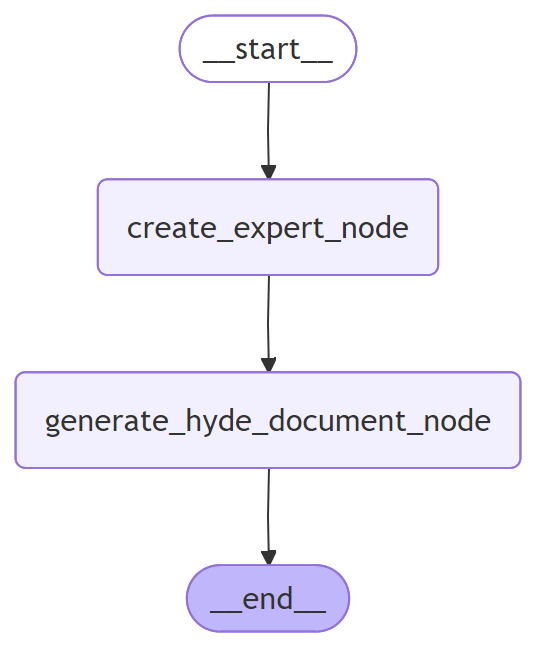

True

In [63]:
mermaid_code = subgraph.get_graph(xray=True).draw_mermaid()
render_mermaid_graph(mermaid_code)

In [64]:
# now we need node to contain subgraph 
def call_subgraph(state:UnifiedResearchState): 
    # collect subgraph output 
    print("Executing call_subgraph... ")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )
    subgraph_output = subgraph.invoke( { "search_topic": state["query_components"][0].search_topic ,
                                         "entity_name": state["query_components"][0].entity_name , 
                                         "max_journalists": state["max_journalists"]
                                        } ) 
    
    print("Executing call_subgraph Done ", end = "\n\n")
    return {
             "hyde_list": subgraph_output["hyde_list"] , 
             "journalists": subgraph_output["journalists"]
           }

#### Prepare module for cosine similarity

In [65]:
## ok test comparison algo , each article is compared against
## HeDe docs

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# we compare 1 article agains max_journalist , the format is ( n_row , n_journalists ) 

text_samples = [
    "The financial institution faces significant regulatory compliance challenges and potential money laundering violations that could impact its banking partnerships.",
    
    "Recent investigations reveal operational risk factors including inadequate anti-money laundering controls and suspicious transaction monitoring failures.",
    
    "Market analysts express concerns about reputational damage from ongoing legal proceedings and regulatory scrutiny affecting stakeholder confidence."
]

url_content = text_samples[1]

## form embedding of original 

vector_url_content = np.array( embedding_cross_lang.embed_query(url_content) )
vector_url_content = vector_url_content.reshape(1,-1)
print(vector_url_content.shape)


(1, 3072)


In [66]:
# function will be iteravely applied over each content 
# It assign max values of cosine score

def check_content_similarity(
    search_results: List[LinkCollection], 
    hyde_list: npt.NDArray[np.float64]
) -> List[LinkCollection]:
    
    """
    Check if URL content has high similarity to any Hyde document
    
    Args:
        search_results: List of LinkCollection objects with raw_content
        hyde_list: numpy array of shape (n, 1536) containing Hyde embeddings
    
    Returns:
        float: Maximum cosine similarity score rounded to hundredth (2 decimal places)
    """
    
    # Store max similarity score for each URL
    updated_collections = []  # stroe new values for the collection, later replace, solution is redundant
    for link in search_results:

        url_content = link.raw_content
        
        # Embed URL content, cap is 300 000 tokens, 1 token is aproximately 4 characters, Embedding error: Error code: 400 - {'error': {'message': 'Requested 307281 tokens, max 300000 tokens per request', 't
        try:
           url_content_embed = np.array(
               embedding_cross_lang.embed_query(url_content[:800000])
           ).reshape(1, -1)
        except Exception as e:
           print(f"Embedding error: {str(e)[:100]}")
           url_content_embed = np.zeros((1, 3072))  # Default embedding for text-embedding-3-large
        
        # calculate similarity scores against all Hyde embeddings
        similarity_scores = cosine_similarity(url_content_embed, hyde_list)
        
        # Find and store max similarity for this URL
        max_score = round(float(np.max(similarity_scores)), 2)
        
        # Must be rewritten , maybe we can modify in place
        # update the state values , fix later 
        updated_collection = LinkCollection(
            displayLink=link.displayLink,
            link=link.link,
            search_engine = link.search_engine,
            summary=link.summary,
            claim_type=link.claim_type, 
            date_published=link.date_published,
            severity_level=link.severity_level, 
            hyde_score=max_score,
            raw_content=link.raw_content,
        )
        
        updated_collections.append(updated_collection)
    
    return updated_collections

# Usage:
#results["search_results"] = check_content_similarity(
#    results["search_results"], 
#    hyde_content_list_embed
#)

# Tools are for external API, actions which requires LLM to decide parameters , sityation whcih required dynamic parameters
# Here we process data which already in a state, no external api, state modification, sequential processing 

In [67]:
## now prepare function to integrate into main flow 
## Node assigns cosine similarity
## Here we read search_results_kw_filter and update it , but it creates duplicates
# same url with and without hyde score 

# this node can create duplicates as if multiple tools are called we need to process only one which dont have hide score

# we turn this node into function, as we can not use 2 reducers on search_results_kw_filter
#c def assign_score_vs_hyde_node(state: UnifiedResearchState) -> UnifiedResearchState :

# REMOVED FROM GRAPH
def assign_score_vs_hyde_node(hyde_list:list,search_results_kw_filter:List[LinkCollection],search_engines_selected:str ) :
    """Node function to estimate similarity score agains HyDe documents"""
    
    ## prepare input for score estimation
    dummy_state = search_results_kw_filter

    print("Executing assign_score_vs_hyde_node...")
    print("Total numner of raw links: " ,  len(dummy_state) )

    ## prepare HydeEmbeddings 
    hyde_content_list = hyde_list #  state.get("hyde_list", None)
    # hyde_content_list_embed = np.vstack([  np.array( embedding_cross_lang.embed_query(article) ).reshape(1,-1) for article in hyde_content_list ])
    print("Total numbe of articles" , len(hyde_content_list) )

    # this part can be repeated only once
    hyde_embeddings = embedding_cross_lang.embed_documents(hyde_content_list)
    hyde_content_list_embed = np.array(hyde_embeddings)

    # collect data only produced with current tool
    tool_selected = search_engines_selected # string type
    links_to_process = [ link for link in dummy_state if link.search_engine == tool_selected  ]

    updated_search_result = check_content_similarity(search_results=links_to_process , hyde_list = hyde_content_list_embed )
    
    print("Executing assign_score_vs_hyde_node  Done", end = "\n\n")

    return {updated_search_result} # replace the searchresult field


In [68]:
## Node to update  state["search_results"] and keep only relevant material for summary 

def filter_semantic_similarity_node(state: UnifiedResearchState) -> UnifiedResearchState:
    """Filter and sort search results by HyDE relevance score"""
    
    print("Executing filter_semantic_similarity_node...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )


    # Calcualte hyde score
    tool_selected = state["search_engines_selected"] # string type
    dummy_state  = state["search_results_kw_filter"].copy()
    links_to_process = [ link for link in dummy_state if link.search_engine == tool_selected  ]
    hyde_content_list = state.get("hyde_list", None)

    hyde_embeddings = embedding_cross_lang.embed_documents(hyde_content_list)
    hyde_content_list_embed = np.array(hyde_embeddings)
    # this return class, we need to extract link and hyde score
    updated_search_result = check_content_similarity(search_results=links_to_process , hyde_list = hyde_content_list_embed )

    # Assign Hide score
    links  = [item.link for item in updated_search_result]
    scores = [item.hyde_score for item in updated_search_result]
    url_hyde_map = {link: score for link, score in zip(links, scores)}

    ## now replace values in the original 
    for item in dummy_state: 
        if item.link in url_hyde_map: 
           item.hyde_score =  url_hyde_map.get(item.link)
    

    # Now Filter Results
    RELEVANCE_THRESHOLD = 0.2  # Configurable
    TOP_K = 30  # Maximum articles to keep
    
    # Filter items with scores
    scored_items = [
        link for link in dummy_state
        if link.hyde_score is not None
    ]
    
    # Sort by score (descending)
    sorted_items = sorted(
        scored_items, 
        key=lambda x: x.hyde_score, 
        reverse=True
    )
    
   # threshold filtering
    threshold_filtered = [it for it in sorted_items if it.hyde_score >= RELEVANCE_THRESHOLD]
    filtered = threshold_filtered[:TOP_K]
    print(f"Above threshold ({RELEVANCE_THRESHOLD}): {len(threshold_filtered)}")
    print(f"Returned (TOP_K={TOP_K}): {len(filtered)}")

    if filtered:
        scores = [item.hyde_score for item in filtered]
        print(f"Score range: {min(scores):.2f} - {max(scores):.2f}")
        print(f"Top 5 sources example: {[item.displayLink[:30] for item in filtered[:5]]}")
    else:
        print("WARNING: No articles passed relevance threshold!")
    
    print("Executing filter_semantic_similarity_node Done", end="\n\n")
    
    return {"search_results_sm_filter": filtered}


#### Evidence Validation

In [69]:
# We need verifiation that final assessment clains are based on the evidence 
# collected as summaries 
# We need to emplly evidence therefore add modules to trace the process

# Eventually, evidences must be collected into reusable sharable format 
# It should help to avoid hallusination and back up arguments with evidences 

# we require consistent deduplication, inproved output structure with more discinplined extraction, lower hallucination
# LengthFinishReasonError: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=4000, prompt_tokens=3174, total_tokens=7174,

def extract_evidence_claims_node(state:UnifiedResearchState) -> Dict: 
    
    """Extract claims from summaries and consolidate duplicate claims across sources"""
    
    print("Extracting and consolidating evidence claims...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )

    # prepare summaries 
    summaries_data = [] # each element is dictionary wish summary data 

      ## check for previous attempts to generate summary 
    if state.get("url_feedback"):
        modifier = state.get("url_feedback").content
        print("⚠️  Retry attempt - incorporating feedback")
    else:    
        modifier = "No previous feedback - first attempt"

    # data for placeholder with evidence 
    for link in state["search_results_sm_filter"]: 
        if link.summary.strip(): 
            summaries_data.append(
                {
                "url": link.link,
                "source": link.displayLink,
                "summary": link.summary, # contains date
                "claim_type": link.claim_type,
                "date_published":link.date_published,
                "severity_level": link.severity_level
                }
            )

    #print("Data from which to consolidate evidences: " , json.dumps(summaries_data, indent=2))

    entity_name = state["query_components"][0].entity_name

    extraction_prompt = f"""
Consolidate financial-crime/compliance claims about {entity_name} from the PRE-CLASSIFIED summaries below.

COMMENTS from previous attempts(ignore if empty)
{modifier}

IMPORTANT
- Do NOT re-classify. Use each item's `claim_type` as ground truth.
- Do NOT invent facts or fields. Use only what is present in the summaries.
- Return ONLY the structured object matching `ClaimsFromSummaries` (no extra text).

INPUT (per item): url, source, summary, claim_type, date_published, severity_level

SCOPE & FILTERS
- Include ONLY items about {entity_name}. If an item focuses on another company, skip it.
- If an affiliate/subsidiary is mentioned, include only if the summary explicitly ties it to {entity_name} (ownership/control/parent–subsidiary stated). Otherwise skip.
- Ignore items that explicitly say there is no information about {entity_name}.
- RAW CONTENT may include boilerplate or unrelated text—ignore noise and use only substantive financial-crime details.

DEFINITION — CLUSTER
- A **cluster** is a set of items that describe the **same underlying event** and share the same `claim_type`.
- “Underlying event” means a single discrete action/outcome (e.g., one fine order, one settlement agreement, one charge/indictment, one conviction/plea, one sanctions listing, one clearance/closure, one investigation opening) concerning {entity_name}.
- Press updates or multiple articles about the **same** order/filing/decision belong to the **same cluster**.
- If there is a **material difference** (e.g., different regulator/agency, different amount/currency, different case number or court, clearly different event dates), treat as **separate clusters** even if wording is similar.
- Each **cluster maps to exactly one `EvidenceClaim`** (one cluster ⇒ one claim).

CONSOLIDATION (NO RE-CLASSIFICATION)
1) Form clusters using semantic overlap in:
   - regulator/agency/court names
   - action (fine/settlement/charge/plea/conviction/investigation/allegation/clearance/sanction_listing)
   - amounts & currency (treat “€1.5B” ≈ “€1,500,000,000”)
   - timeframe or event date window
   - jurisdiction/country/court
   When uncertain, prefer merging items with higher `severity_level`; if still unsure, keep separate claims.

2) For each cluster, output ONE `EvidenceClaim`:
   - `claim_text`: One precise sentence for {entity_name} capturing shared details (amounts, agency, timeframe, jurisdiction). If sources conflict on a detail, omit that detail rather than guessing.
   - `claim_type`: COPY from the clustered items (do not change).
   - `supporting_urls`: ALL unique URLs from the cluster. Deduplicate. Order by descending `severity_level`; if scores tie or are missing, preserve first appearance.
   - `date_publish`: choose in this order:
       a) A clear event date in the summaries (YYYY-MM-DD).
       b) Else the most recent non-"Unknown" publication date among the clustered items.
       c) Else "Unknown".

3) If items refer to the same matter but have DIFFERENT `claim_type` (e.g., investigation → settlement → clearance), output SEPARATE claims (one per type).

FORMAT RULES
- `date_publish` must be "YYYY-MM-DD" or "Unknown".
- If no valid claims remain after filtering, return `evidence_claims: []`.
- Sort `evidence_claims` by `date_publish` ascending; place "Unknown" dates last.

Summaries to analyze:
{json.dumps(summaries_data, indent=2)}
"""

    messages = SystemMessage(content= f"""
                                You are a forensic Financial Crimes Analysts of company {entity_name}

                                Follow these constraints:
                                - Use only information contained in the user message; do not add outside knowledge.
                                - Do not guess missing details (dates, amounts, agencies).
                                - Produce consolidated, non-duplicative claims and include provenance (supporting URLs).
                                - Choose exactly one claim_type per claim, using the schema provided by the user.
                                - If nothing qualifies under these constraints, return an empty list.
                                
                                """ ), HumanMessage(content=extraction_prompt)    

    # debug
    #print(json.dumps(summaries_data, indent=2))
    for max_tokens in [1500, 2500, 3500, 4500, 5000]:
        try:
            structured_llm = llm_agg_summaries.with_structured_output(ClaimsFromSummaries).bind(max_tokens=max_tokens)
            response = structured_llm.invoke(messages)
            
            print(f"✓ Success with {max_tokens} tokens")
            print(f"Extracted {len(response.evidence_claims)} unique claims from {len(summaries_data)} summaries")
            print(response.evidence_claims)
            return {"evidence_claims": response.evidence_claims}
            
        except Exception as e:
            if "length" in str(e).lower() or "token" in str(e).lower():
                print(f"❌ Failed with {max_tokens} tokens, trying higher limit...")
                if max_tokens == 5000:
                    print("Maximum token limit reached, still failing")
                    raise e
                continue
            else:
                # Re-raise if it's not a token/length error
                raise e
               

# By explicitly listing available URLs, you risk the LLM making incorrect associations between summaries and URL

In [70]:
#dummy_state.update( extract_evidence_claims_node (dummy_state) )
# LengthFinishReasonError: Could not parse response content as the length limit was reached - 
# CompletionUsage(completion_tokens=2000, prompt_tokens=11245, total_tokens=13245, 

In [71]:
## Check for hallucinated URLs
def url_verification_node(state: UnifiedResearchState):

    print("Executing url_verification_node...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )

    url_in_evidence = []
    for evidence in state.get("evidence_claims", []):
        url_in_evidence.extend(evidence.supporting_urls)

    url_in_collection = [link.link for link in state.get("search_results_raw", [])]

    # Convert to sets
    url_in_evidence_set = set(url_in_evidence)
    url_in_collection_set = set(url_in_collection)

    # Find hallucinated URLs
    hallucinated = url_in_evidence_set - url_in_collection_set

    print(f"Validation Report:")
    print(f"Evidence URLs: {len(url_in_evidence)}")
    print(f"Collection URLs: {len(url_in_collection)}")
    print(f"Hallucinated: {len(hallucinated)}")

    if hallucinated:
        print(f"\nHallucinated URLs:")
        for url in hallucinated:
            print(f"  {url}")
        
        # Convert set to comma-separated string
        hallucinated_urls_str = ", ".join(hallucinated)
        
        # Create feedback prompt
        prompt = f"""You were given the task to consolidate evidence claims. However, your final conclusion 
referenced URLs which do not exist in the provided evidence collection.

**Hallucinated URLs ({len(hallucinated)}):**
{hallucinated_urls_str}

**Instructions:**
- ONLY use URLs that are present in the evidence collection
- Review each evidence claim and ensure all supporting_urls are valid
- Remove or replace any hallucinated URLs with actual URLs from the collection
- Maintain the same level of detail and quality in your evidence claims

Please repeat the consolidation process with strict focus on using ONLY the URLs that were actually provided in the search results."""
        
        ai_message = AIMessage(content=prompt)
        
        return {"url_feedback": ai_message}
    
    else:
        print("\nNo hallucinations detected")
        return {"url_feedback": None}
    

# Routing function - decides next step
def route_evidence_validation(state: UnifiedResearchState):
    """Route based on evidence feedback"""
    if state.get("url_feedback") is None:
        print("✓ Validation passed - proceeding", end = "\n\n")
        return "continue"  # or "generate_report", whatever your next step is
    else:
        print("✗ Hallucinations detected - repeating consolidation", end = "\n\n")
        return "consolidate_evidence"  # back to your consolidation node extract_evidence_claims_node


In [72]:
## we need node which checks if we collected enough evidences
def reflect_evidence_quality_node(state: UnifiedResearchState):

    print("Execute reflect_evidence_quality_node...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )

    entity_name = state['query_components'][0].entity_name
    search_topic = state['query_components'][0].search_topic

    types = {c.claim_type for c in state["evidence_claims"]}  # its a set 
    claims_by_type = {t: [] for t in types}
    print("Claim types:", sorted(types))

    ## now prepare input for final summarisation prompt 
    print("Iterate through claim cases: ")
    for claim in state["evidence_claims"]:
        claims_by_type[claim.claim_type].append({
            "text": claim.claim_text,
            "sources": ", ".join(claim.supporting_urls),
            "number of evidences": len(claim.supporting_urls), 
            "date_publish": claim.date_publish
        })

    sections = []
    for t in sorted(claims_by_type.keys()):
        items = claims_by_type[t]
        if not items:
            continue
        title = t.replace("_", " ").upper()
        
        # Add evidence numbering
        numbered_items = []
        for idx, item in enumerate(items, 1):
            numbered_items.append(f"EVIDENCE {idx}:\n{json.dumps(item, indent=2, ensure_ascii=False)}")
        
        sections.append(f"{title}:\n" + "\n\n".join(numbered_items))

    evidence_block = "\n\n".join(sections) if sections else "No evidence available."    
    print(evidence_block)

    system_prompt = f"""You are a long-time customer of {entity_name}. You have a business relationship with them that you value.
However , you are very cautions about company reputation as its directly imparct your business. 
Recently, you came across concerning information online suggesting {entity_name} may be connected to "{search_topic}".

This worries you because:
- Your reputation could be affected by association
- You need to know if this is credible or just rumors
- You want to make an informed decision about continuing the relationship

Below is the evidence you've gathered so far:

{evidence_block}

WHAT WOULD CONVINCE YOU:
- **Multiple credible sources** (official records preferred)
- **Specific details** (dates, amounts, agencies, jurisdictions)
- **Recent or ongoing matters** (active investigations, current sanctions)
- Evidence from authoritative sources (government agencies, regulators, established media)

WHAT WOULD MAKE YOU WANT MORE INFORMATION:
- Only one weak source
- Extremely vague claims with no details
- Sources appear unreliable or fabricated
- No information at all about the topic

Be honest: Does this evidence give you enough information to form a confident opinion about whether {entity_name} is truly involved in "{search_topic}", or do you need to dig deeper?

Return "convinced" if you have enough to make a decision (whether to stay or leave).
Return "repeat_search" if you're still uncertain and need more solid evidence."""

    structured_llm = llm_agg_summaries.with_structured_output(AssessEvidenceQuality)
    
    response = structured_llm.invoke([
        SystemMessage(content=system_prompt)
    ])
    
    print(f"\n🔧🔧 Evidence Assessment: {response.evidence_quality}")
    print(f"Reasoning: {response.reasoning}")
    print("Execute reflect_evidence_quality_node Done", end="\n\n")
    return {"evidence_feedback":response }

In [73]:
## condition node to try another tool 
def route_should_run_tool(state:UnifiedResearchState): 
    dummy_state = state.get("evidence_feedback", None)
    if dummy_state.evidence_quality == 'convinced':
        return "generate_risk_assessment_node"
    else:
        return "tool_selection_node"

In [81]:
# adjust summarisation node 

def generate_risk_assessment_node(state: UnifiedResearchState):
    """Generate comprehensive AML risk assessment from evidence claims"""
    
    print("Executing generate_risk_assessment_node...")
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )
    
    print("State keys" , state.keys())
    types = {c.claim_type for c in state["evidence_claims"]}
    claims_by_type = {t: [] for t in types}

    print("Claim types:", sorted(types)) # myst be fine investigation, allegation, clearance, settlement
    
    ## now prepare input for final summarisation prompt 
    print("Iterate through claim cases: ")
    for claim in state["evidence_claims"]:
        claims_by_type[claim.claim_type].append({
            "text": claim.claim_text,
            "sources": ", ".join(claim.supporting_urls),
            "date_publish":claim.date_publish
        })
    
    entity_name = state["query_components"][0].entity_name
    
    system_message = SystemMessage(content=f"""
    You are a senior AML compliance officer conducting risk assessment for {entity_name}.
    
    Analyze the evidence to determine banking partnership viability.
    
    KEY ASSESSMENT CRITERIA:
    
    1. VIOLATION SEVERITY
    - Calculate total fines from the evidence (don't hardcode)
    - Identify the scale of violations (amounts involved vs fines paid)
    - Determine if violations were systemic or isolated
    
    2. CURRENT RISK STATUS
    - Count active investigations (ongoing = unresolved risk)
    - Identify investigating authorities 
    - Assess geographic spread (multiple jurisdictions = higher risk)
    - Evaluate timeline and provide quote with date in ISO 8601 format (recent violations = weak current controls)
    
    3. CONTROL ENVIRONMENT
    - Evaluate settlement efforts (genuine improvement vs PR)
    - Check for leadership accountability (executives resigned?)
    - Assess system improvements (new AML systems, training?)
    
    4. PATTERN RECOGNITION
    - Multiple fines for similar issues = poor compliance culture
    - Repeated violations across years = systemic failure
    - Mix of old violations + strong settlement = possible reform
    
    DECISION FRAMEWORK:
    
    AVOID PARTNERSHIP if:
    - Criminal investigations ongoing
    - Multiple violations without meaningful settlement
    - Pattern of violations continuing to present
    - Total fines exceed €1 billion with no improvement
    
    ENHANCED DUE DILIGENCE if:
    - Significant past violations but settled
    - Active settlement program with evidence
    - Civil investigations ongoing (not criminal)
    - Mix of violations and clearances
    
    
    REQUIRED OUTPUT:
    1. EXECUTIVE SUMMARY: Core issues and total financial impact (calculate from evidence)
    2. VIOLATION ANALYSIS: What they did wrong and when
    3. CURRENT STATUS: What's resolved vs ongoing
    4. TRAJECTORY: Getting better or worse? (compare dates)
    5. RISK RATING: HIGH/MEDIUM/LOW with specific justification
    6. PARTNERSHIP RECOMMENDATION: Your decision with conditions
    
    Be specific about amounts, dates, and authorities involved.

    Each Summary must end with structurem here is example, Keep same criteria but
    Content for Status/Details can vary

    **Summary Table**

| Criteria                | Status/Details                                           |
|-------------------------|---------------------------------------------------------|
| Total Fines Paid        | €0                                                      |
| Most Serious Issue      | Ongoing criminal investigation for money laundering     |
| Ongoing Risk?           | Yes (as of 2025-09-16)                                  |
| Investigating Authority | Moldovan law enforcement                                |
| Geographic Spread       | Moldova only                                            |
| Settlement Efforts      | None reported                                           |
| Risk Rating             | HIGH                                                    |
| Recommendation          | AVOID PARTNERSHIP                                       |

    """)
    
    # Prepare evidence for analysis
    # Build evidence_prompt dynamically (no hardcoded claim types)
    sections = []
    for t in sorted(claims_by_type.keys()):
        items = claims_by_type[t]
        if not items:
            continue
        title = t.replace("_", " ").upper()  # simple, generic prettifier
        sections.append(f"{title}:\n{json.dumps(items, indent=2, ensure_ascii=False)}")

    evidence_block = "\n\n".join(sections) if sections else "No evidence available."

    evidence_prompt = (
        f"Evidence for {entity_name}:\n\n"
        f"{evidence_block}\n\n"
        "Based on this evidence:\n"
        "1. Calculate the total fines paid\n"
        "2. Identify the most serious issue (hint: look for large transaction amounts)\n"
        "3. Determine if this is historical or ongoing risk\n"
        "4. Make your partnership recommendation with clear reasoning\n"
    )

    print("Evidence Prompt: " , evidence_prompt, end = "/n/n" )
    print("Request LLM Response of Final Conclusion ")
    messages = [system_message, HumanMessage(content=evidence_prompt)]

    analysis_response = llm_evaluation.invoke(messages)
    
    print("Risk assessment completed")
    return {"final_conclusion": analysis_response}


In [82]:
## We have to join data before assigning scores
# state is updates with data from both flows but without interaction
#def join_node(state: UnifiedResearchState):
#    """
#    Simple pass-through node that waits for both paths to complete
#    """
#    print("Both paths completed, proceeding to scoring...")
#    return state
# !! joining 2 states means duplicating data is part of information is shared
# it can cause error both thet we repeat same information, but it also required all data to have reducers
# The join node receives two separate state updates from the parallel paths, and when it tries to merge them, some keys have different values or duplicated data


def buffer_node_hyde_generation(state: UnifiedResearchState):

    """
    Used to maintain split between deterministic and conditional nodes
    """
    print("Total numner of raw links: " ,  len(state["search_results_raw"]) )
    
    return {} # dont use state or we will duplicate all data 

# we will isolate conditional logic i have iisue with nodes timing 


Graph rendered successfully: graph.png


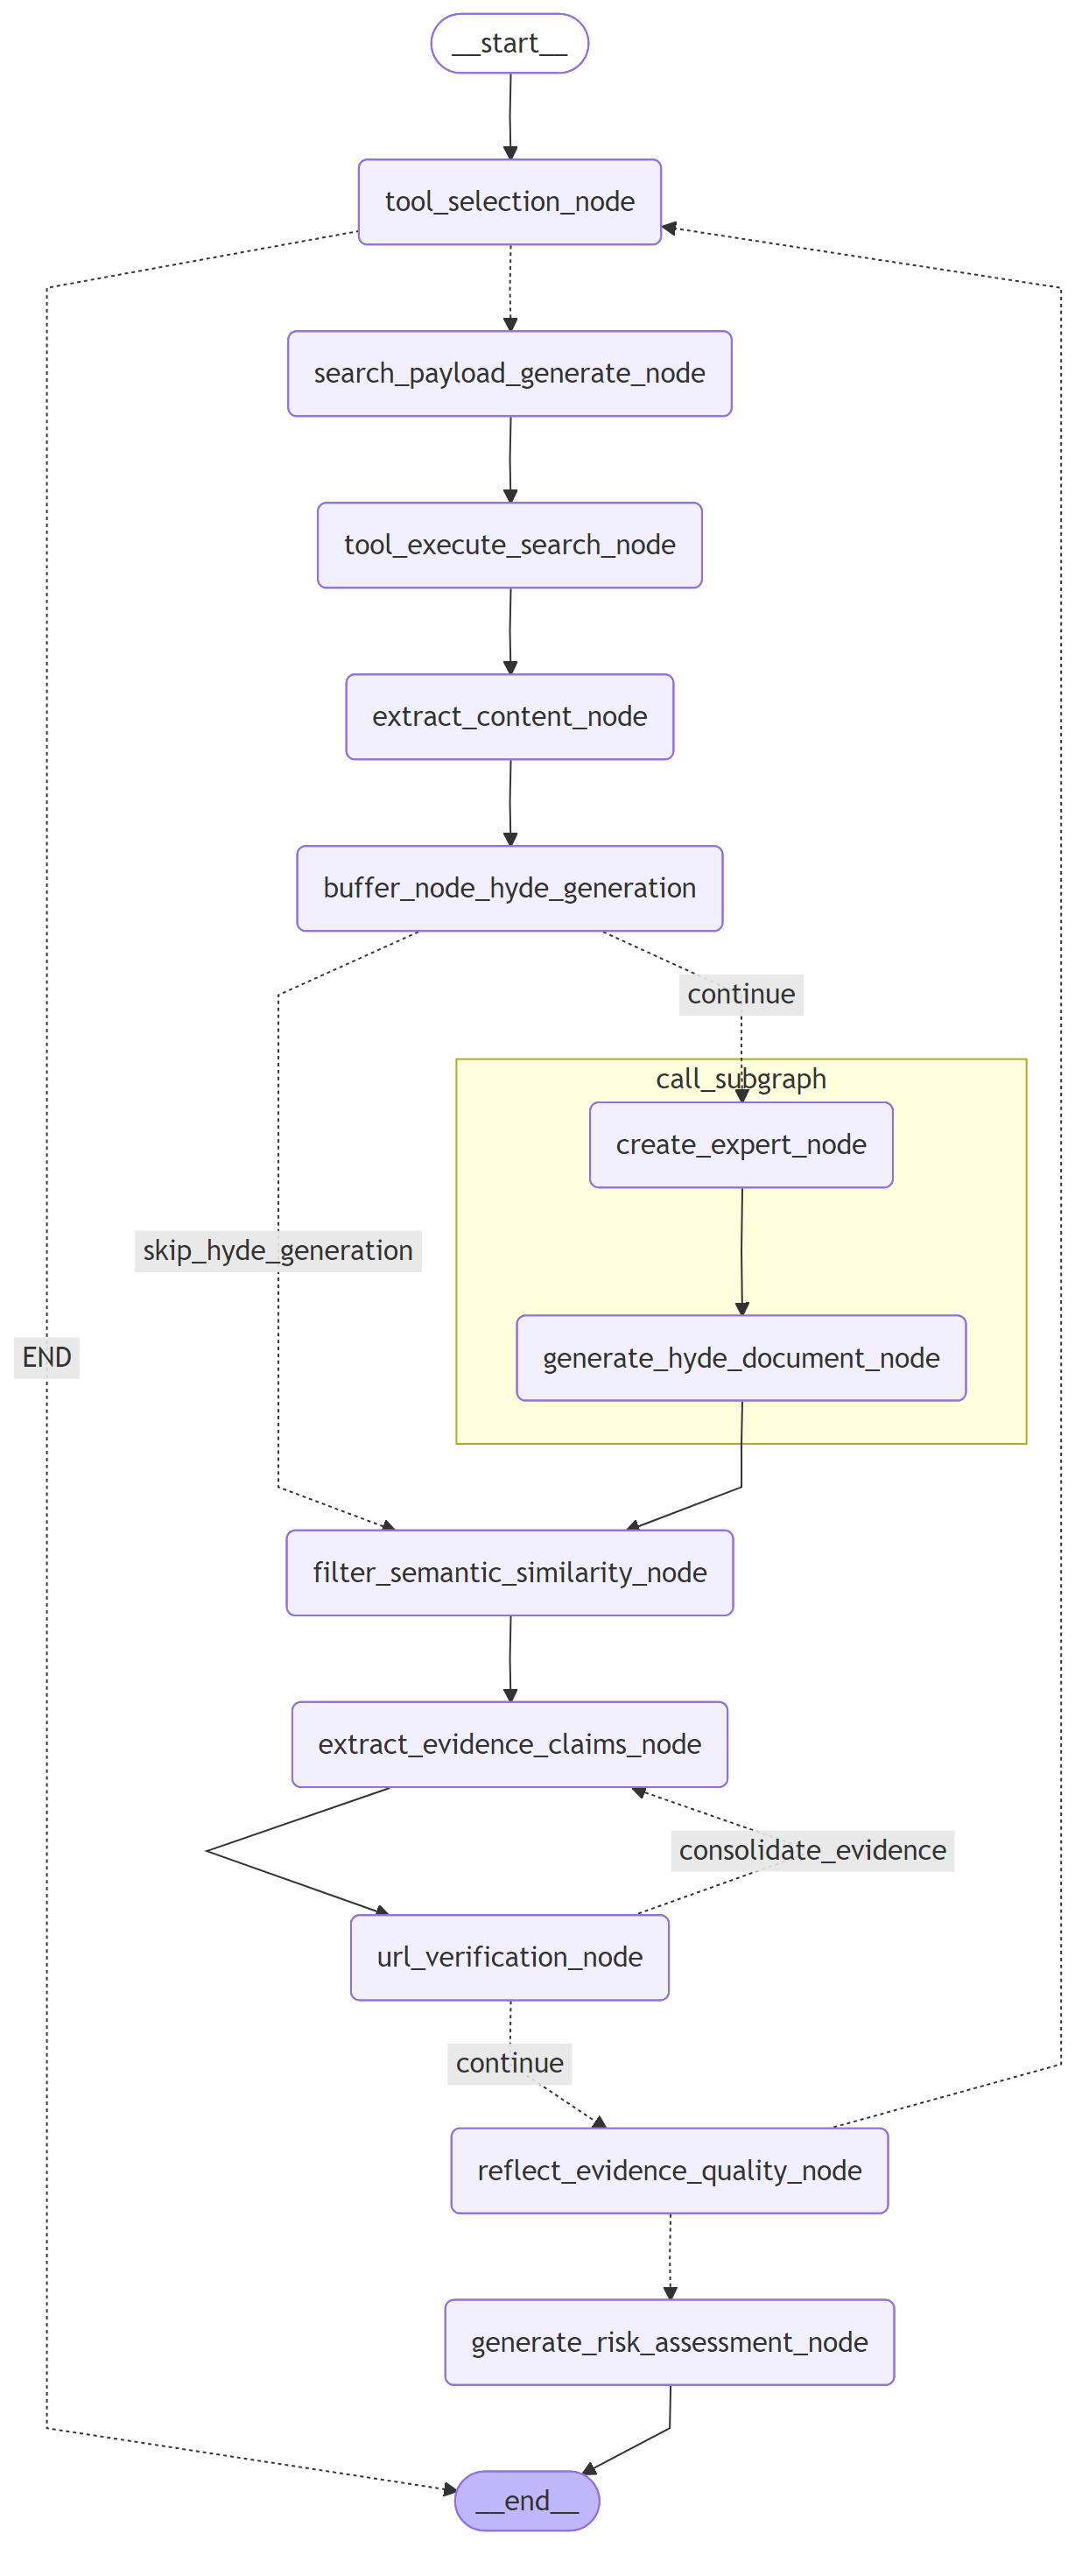

True

In [83]:
## add node to the workflow 

# assemble agent
builder = StateGraph(UnifiedResearchState)

# content extraction
builder.add_node("tool_selection_node", tool_selection_node)
builder.add_node("search_payload_generate_node", search_payload_generate_node)
builder.add_node("tool_execute_search_node", tool_execute_search_node)
builder.add_node("extract_content_node", extract_content_node)

# content semantic filtering 
#builder.add_node("assign_score_vs_hyde_node", assign_score_vs_hyde_node)
builder.add_node("filter_semantic_similarity_node", filter_semantic_similarity_node)

# evidence generation and conclusion
builder.add_node("generate_risk_assessment_node", generate_risk_assessment_node)
builder.add_node("extract_evidence_claims_node", extract_evidence_claims_node)

# evidence quality assesment 
builder.add_node("url_verification_node", url_verification_node)
builder.add_node("reflect_evidence_quality_node", reflect_evidence_quality_node)

# hyde generation
builder.add_node("call_subgraph", call_subgraph)

builder.add_node("buffer_node_hyde_generation",buffer_node_hyde_generation)



########  logic 
# content extraction
builder.add_edge(START, "tool_selection_node") # intiate process

builder.add_conditional_edges( # check of we have rools available
    source="tool_selection_node", 
    path=route_trigger_search, 
    path_map={"END": END, "search_payload_generate_node": "search_payload_generate_node"}
) # payload always generated

# what if tools are avaible and payload generated
# we can either generate hyde or skip it
builder.add_edge("search_payload_generate_node", "tool_execute_search_node")
builder.add_edge("tool_execute_search_node", "extract_content_node")
builder.add_edge("extract_content_node", "buffer_node_hyde_generation") # buffer node is ised to isolate logic and narrow 2 directions
                                                                # enrich with hyde or skip it 

builder.add_conditional_edges(
    source="buffer_node_hyde_generation",
    path=route_expert_generation,
    path_map={
        "continue": "call_subgraph",
        "skip_hyde_generation": "filter_semantic_similarity_node"
    }
)

builder.add_edge("call_subgraph", "filter_semantic_similarity_node")

# evidence validation loop
#builder.add_edge("assign_score_vs_hyde_node", "filter_semantic_similarity_node")
builder.add_edge("filter_semantic_similarity_node", "extract_evidence_claims_node")
builder.add_edge("extract_evidence_claims_node", "url_verification_node")

builder.add_conditional_edges(
    source="url_verification_node", 
    path=route_evidence_validation, 
    path_map={
        "continue": "reflect_evidence_quality_node",
        "consolidate_evidence": "extract_evidence_claims_node"  # loops back
    }
)

builder.add_conditional_edges(
    source="reflect_evidence_quality_node", 
    path=route_should_run_tool, 
    path_map={
        "generate_risk_assessment_node": "generate_risk_assessment_node",
        "tool_selection_node": "tool_selection_node"  # loops back
    }
)


# final step
builder.add_edge("generate_risk_assessment_node", END)

# assemble agent
graph = builder.compile()

mermaid_code = graph.get_graph(xray=True).draw_mermaid()
render_mermaid_graph(mermaid_code)

#### Test Cases

In [77]:
## Case , no tool available, OK
# Moldretail Lukoil  Wachovia Bank     HSBC    Dankse Bank Moldindconbank
# Finpar Invest  danube logistics

## search parameters
qc = QueryComponentsCalc("Lukoil", "money laundering financial crime")
qc.translate_query_for_search(llm_translation_or_terms)

first_input = QueryComponentsinState(
    entity_name=qc.entity_name,
    search_topic=qc.search_topic,
    query_collection=qc.query_collection,
    entity_names_variations=qc.entity_names_variations,
    google_search_modifier_entity=qc.google_search_modifier_entity,
    google_search_modifier_exc_domain = qc.google_search_modifier_exc_domain
)
print(first_input)

results = graph.invoke(   
               {
                    "messages" : [],
                    "max_journalists": 5,
                    "journalists": [],  # Will be populated by create_journalists node
                     "hyde_list": [],     # Will be populated by generate_hyde_document node
                    "num_requests_per_lang":5,
                    "query_components":[first_input],
                    "search_engines_used":["google_search","tavily_search","perplexity_search"] 
                    
                } , {"recursion_limit":50} )
# "max_journalists": 6, 10 links per language 

# GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key

Translated 'Lukoil money laundering financial crime' -> 'Lukoil money laundering financial crime' (English)
Translated 'Lukoil money laundering financial crime' -> 'Лукойл отмывание денег финансовые преступления' (Russian)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil blanchiment d'argent crime financier' (French)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil spălare de bani infracțiuni financiare' (Romanian)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil Geldwäsche Finanzkriminalität' (German)
entity_name='Lukoil' search_topic='money laundering financial crime' query_collection={'ro': 'Lukoil spălare de bani infracțiuni financiare', 'ru': 'Лукойл отмывание денег финансовые преступления', 'fr': "Lukoil blanchiment d'argent crime financier", 'en': 'Lukoil money laundering financial crime', 'de': 'Lukoil Geldwäsche Finanzkriminalität'} entity_names_variations=['Lukoil', 'Лукоил'] google_search_modifier_entity='intext:"Lukoil" OR intext

In [84]:
# Test, Hyde is non empty
qc = QueryComponentsCalc("Lukoil", "money laundering financial crime") 
qc.translate_query_for_search(llm_translation_or_terms)
# https://weltwoche.ch/daily/rette-sich-wer-kann-die-eu-ruestet-zum-totalitaeren-ueberwachungsstaat-und-bereitet-enteignungen-vor-mit-hilfe-der-union/
  # comments contain blablabla, we still require solid sematic rag like filtering
  # maybe we can create in advance 20 aml related topics 

first_input = QueryComponentsinState(
    entity_name=qc.entity_name,
    search_topic=qc.search_topic,
    query_collection=qc.query_collection,
    entity_names_variations=qc.entity_names_variations,
    google_search_modifier_entity=qc.google_search_modifier_entity,
    google_search_modifier_exc_domain = qc.google_search_modifier_exc_domain
)
print(first_input)

# run test
import traceback 

try:
  results = graph.invoke(   
                {
                      "messages" : [],
                      "max_journalists": 10,
                      "journalists": [],  # Will be populated by create_journalists node
                      "hyde_list": [],     # Will be populated by generate_hyde_document node
                      "num_requests_per_lang":10,
                      "query_components":[first_input],
                      "search_engines_used":[]
                      
                  }, {"recursion_limit":50}  )
except Exception as e:
    print("="*80)
    print("FULL ERROR TRACEBACK:")
    print("="*80)
    traceback.print_exc()
    print("="*80)
    print(f"Error type: {type(e).__name__}")
    print(f"Error message: {str(e)}")  
  

Translated 'Lukoil money laundering financial crime' -> 'Lukoil money laundering financial crime' (English)
Translated 'Lukoil money laundering financial crime' -> 'Лукойл отмывание денег финансовые преступления' (Russian)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil blanchiment d'argent crime financier' (French)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil spălare de bani infracțiuni financiare' (Romanian)
Translated 'Lukoil money laundering financial crime' -> 'Lukoil Geldwäsche Finanzkriminalität' (German)
entity_name='Lukoil' search_topic='money laundering financial crime' query_collection={'ro': 'Lukoil spălare de bani infracțiuni financiare', 'ru': 'Лукойл отмывание денег финансовые преступления', 'fr': "Lukoil blanchiment d'argent crime financier", 'en': 'Lukoil money laundering financial crime', 'de': 'Lukoil Geldwäsche Finanzkriminalität'} entity_names_variations=['Lukoil', 'Лукоил'] google_search_modifier_entity='intext:"Lukoil" OR intext

In [79]:
results

{'messages': [HumanMessage(content='Execute all 5 google_search searches now in parallel for all languages', additional_kwargs={}, response_metadata={}, id='77995997-14b3-41b3-ba94-5617b372084b'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 838, 'prompt_tokens': 2803, 'total_tokens': 3641, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CdxWTWHdHJFt0M6vGHdwSdLp9wimK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--e460c2e3-144a-4991-b4c5-8d6dd6565f75-0', tool_calls=[{'name': 'google_search', 'args': {'query': 'Lukoil spălare de bani infracțiuni financiare', 'google_search_modifier_entity': 'intex

In [89]:
print(results["final_conclusion"].content)

**1. EXECUTIVE SUMMARY**

Lukoil is currently subject to extensive, ongoing criminal investigations and international sanctions across multiple jurisdictions. The most serious issue is the alleged money laundering and tax evasion in Romania, with asset freezes exceeding €2 billion. No evidence of fines paid is reported; instead, asset seizures and freezes are in place. The risk is ongoing and escalating, with recent sanctions imposed by the U.S., UK, and other Western allies in late 2025, and active criminal investigations in Romania. The geographic spread includes the U.S., UK, EU, Switzerland, Canada, Australia, New Zealand, Ukraine, and Romania, indicating a global compliance risk. There is no evidence of meaningful settlement, leadership accountability, or system improvements.

**Total Financial Impact:**  
- **Total fines paid:** €0 (no fines reported; asset freezes > €2 billion)
- **Asset freezes/seizures:** > €2 billion (Romania), plus global asset freezes via sanctions

---

**

#### Select components to export

In [80]:
## data used for the conclusion
#evidence_collection = [] 
#for elem in results.get("search_results_raw"):
#    if elem.summary:
#        out = elem.model_dump( exclude={"raw_content", "hyde_score"} )
#        evidence_collection.append(out)
        
#evidence_collection    